<a href="https://colab.research.google.com/github/teobras/Book-code-Pandas-Cookbook-by-Theodore-Patrou/blob/master/Article_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Instalar Bibliotecas

In [ ]:

%%capture
!pip install arch
!pip install termcolor
!pip install pmdarima
!pip install darts
!pip install optuna
!pip install xlsxwriter

# ===============================
# IMPORTAÇÃO DE BIBLIOTECAS
# ===============================

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPRegressor
import pmdarima as pm

import statsmodels.api as sm
from arch import arch_model

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from darts import TimeSeries

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# 2. Carregar Dados

In [ ]:
# ======================================================
# 1. Montar Google Drive no Colab
# ======================================================
from google.colab import drive
drive.mount('/content/drive')

# ======================================================
# 2. Importar bibliotecas necessárias
# ======================================================
import pandas as pd

# ======================================================
# 3. Definir caminhos dos ficheiros na Google Drive
#    (ajusta a pasta conforme onde guardaste)
# ======================================================

# Exemplo: ficheiros estão na pasta principal "My Drive"
path_cambio = '/content/drive/MyDrive/Colab_Notebooks/Datasets/cambio.csv'
path_inflacao = '/content/drive/MyDrive/Colab_Notebooks/Datasets/inflacao.csv'
path_petroleo='//content/drive/MyDrive/Colab_Notebooks/Datasets/petroleo.csv'

# Se forem ficheiros Excel:
# path_inflacao = '/content/drive/My Drive/INFL_BNA.xlsx'
# path_pib = '/content/drive/My Drive/PIB_BNA.xlsx'

# ======================================================
# 4. Carregar os datasets (CSV ou Excel)
# ======================================================

# Para CSV:
cambio = pd.read_csv(path_cambio)
inflacao = pd.read_csv(path_inflacao)
petroleo = pd.read_csv(path_petroleo)


# Para Excel (se for o caso):
# inflacao = pd.read_excel(path_inflacao)
# pib = pd.read_excel(path_pib)

# ======================================================
# 5. Ver 5 primeiras linhas
# ======================================================
print("\n Dados do Cambio:")
display(cambio.head())

print("\n Dados da Inflação:")
display(inflacao.head())

print("\n Dados do Petroleo:")
display(petroleo.head())

# ======================================================
# 6. Converter coluna Date para formato datetime
# ======================================================
cambio['date'] = pd.to_datetime(cambio['date'])
inflacao['date'] = pd.to_datetime(inflacao['date'])
petroleo['date'] = pd.to_datetime(petroleo['date'])

# ======================================================
# 7. Ordenar por data (opcional mas recomendado)
# ======================================================
cambio = cambio.sort_values('date')
inflacao = inflacao.sort_values('date')
petroleo = petroleo.sort_values('date')

# ======================================================
# 8. Mostrar informação geral
# ======================================================
print("\n Info Cambio:")
print(cambio.info())
print("\n Info Inflação:")
print(inflacao.info())

print("\n Petroleo:")
print(petroleo.info())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

 Dados do Cambio:


,date,cambio
0,2020-12-04,-0.340
1,2020-12-07,-0.368
2,2020-12-08,-0.393
3,2020-12-09,-0.384
4,2020-12-10,-0.399



 Dados da Inflação:


,date,inflacao
0,2020-12-07,1.88
1,2020-12-08,1.89
2,2020-12-09,1.91
3,2020-12-10,1.88
4,2020-12-11,1.87



 Dados do Petroleo:


,date,petroleo
0,2020-12-01,47.03
1,2020-12-02,47.80
2,2020-12-03,48.37
3,2020-12-04,49.10
4,2020-12-07,48.63



 Info Cambio:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1305 non-null   datetime64[ns]
 1   cambio  1249 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 20.5 KB
None

 Info Inflação:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1305 non-null   datetime64[ns]
 1   inflacao  1250 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 20.5 KB
None

 Petroleo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1305 non-null   datetime64[ns]
 1   petro

# 3. Limpeza e Preparação de Dados

In [ ]:
# -------------------------------------------
# 1. IMPORTAR BIBLIOTECAS
# -------------------------------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# --------------------------------------------
# 2. LIMPAR OS NOMES DAS COLUNAS
# -------------------------------------------
cambio.columns   = cambio.columns.str.strip()
inflacao.columns = inflacao.columns.str.strip()
petroleo.columns = petroleo.columns.str.strip()

# Identificar colunas de datas automaticamente
possiveis_datas = ['Date', 'DATA', 'Data', 'date', 'Periodo', 'periodo']

# Resetar o índice se a coluna de data já for o índice
if cambio.index.name in possiveis_datas:
    cambio = cambio.reset_index()
if inflacao.index.name in possiveis_datas:
    inflacao = inflacao.reset_index()
if petroleo.index.name in possiveis_datas:
    petroleo = petroleo.reset_index()

col_data_cambio   = [c for c in cambio.columns if c in possiveis_datas][0]
col_data_inflacao = [c for c in inflacao.columns if c in possiveis_datas][0]
col_data_petroleo = [c for c in petroleo.columns if c in possiveis_datas][0]

# Converter para datetime
cambio[col_data_cambio]       = pd.to_datetime(cambio[col_data_cambio])
inflacao[col_data_inflacao]   = pd.to_datetime(inflacao[col_data_inflacao])
petroleo[col_data_petroleo]   = pd.to_datetime(petroleo[col_data_petroleo])

# Ordenar
cambio    = cambio.sort_values(col_data_cambio)
inflacao  = inflacao.sort_values(col_data_inflacao)
petroleo  = petroleo.sort_values(col_data_petroleo)

# -------------------------------------------
# 3. REMOVER MISSING VALUES
# -------------------------------------------
cambio   = cambio.dropna()
inflacao = inflacao.dropna()
petroleo = petroleo.dropna()

print("Após remoção de missing:")
print(cambio.isna().sum())
print(inflacao.isna().sum())
print(petroleo.isna().sum())

# -------------------------------------------
# 4. AJUSTES / CRIAR LOG-TRANSFORMATION
# -------------------------------------------
# Criar colunas log (somente se valores > 0)

# Câmbio
if (cambio.iloc[:,1] > 0).all():
    cambio["log_cambio"] = np.log(cambio.iloc[:,1])
else:
    print("⚠ Câmbio contém valores <= 0 — log não aplicado.")

# Inflação
if (inflacao.iloc[:,1] > 0).all():
    inflacao["log_inflacao"] = np.log(inflacao.iloc[:,1])
else:
    print("⚠ Inflação contém valores <= 0 — log não aplicado.")

# Petróleo
if (petroleo.iloc[:,1] > 0).all():
    petroleo["log_petroleo"] = np.log(petroleo.iloc[:,1])
else:
    print("⚠ Petróleo contém valores <= 0 — log não aplicado.")

# -------------------------------------------
# 5. UNIFICAR FREQUÊNCIA TEMPORAL (mensal)
# -------------------------------------------
cambio    = cambio.set_index(col_data_cambio).resample("M").mean()
inflacao  = inflacao.set_index(col_data_inflacao).resample("M").mean()
petroleo  = petroleo.set_index(col_data_petroleo).resample("M").mean()

# Interpolar valores faltantes
cambio    = cambio.interpolate()
inflacao  = inflacao.interpolate()
petroleo  = petroleo.interpolate()

# -------------------------------------------
# 6. JUNTAR NUM ÚNICO DATAFRAME
# -------------------------------------------
df = cambio.merge(inflacao, left_index=True, right_index=True, how="inner")\
           .merge(petroleo, left_index=True, right_index=True, how="inner")

# Renomear colunas
# A lista de colunas precisa corresponder ao número de colunas no df.
# Como 'log_cambio' não foi criado, removemos ele da lista de renomeação.
df.columns = ["Cambio", "Inflacao", "log_inflacao", "Petroleo", "log_petroleo"]

# -------------------------------------------
# 7. NORMALIZAÇÃO
# -------------------------------------------
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df),
    columns=df.columns,
    index=df.index
)

print("\n LIMPEZA E PREPARAÇÃO CONCLUÍDA!")
print(df_scaled.head())

Após remoção de missing:
date      0
cambio    0
dtype: int64
date            0
inflacao        0
log_inflacao    0
dtype: int64
date            0
petroleo        0
log_petroleo    0
dtype: int64
⚠ Câmbio contém valores <= 0 — log não aplicado.

 LIMPEZA E PREPARAÇÃO CONCLUÍDA!
              Cambio  Inflacao  log_inflacao  Petroleo  log_petroleo
date                                                                
2020-12-31  0.020635  0.000000      0.000000  0.000000      0.000000
2021-01-31  0.028369  0.158888      0.188236  0.065739      0.101700
2021-02-28  0.075627  0.262055      0.303255  0.168912      0.244659
2021-03-31  0.154985  0.361863      0.409691  0.212004      0.299330
2021-04-30  0.143793  0.439775      0.489725  0.203705      0.289007


# 4. Análise Exploratória de Dados

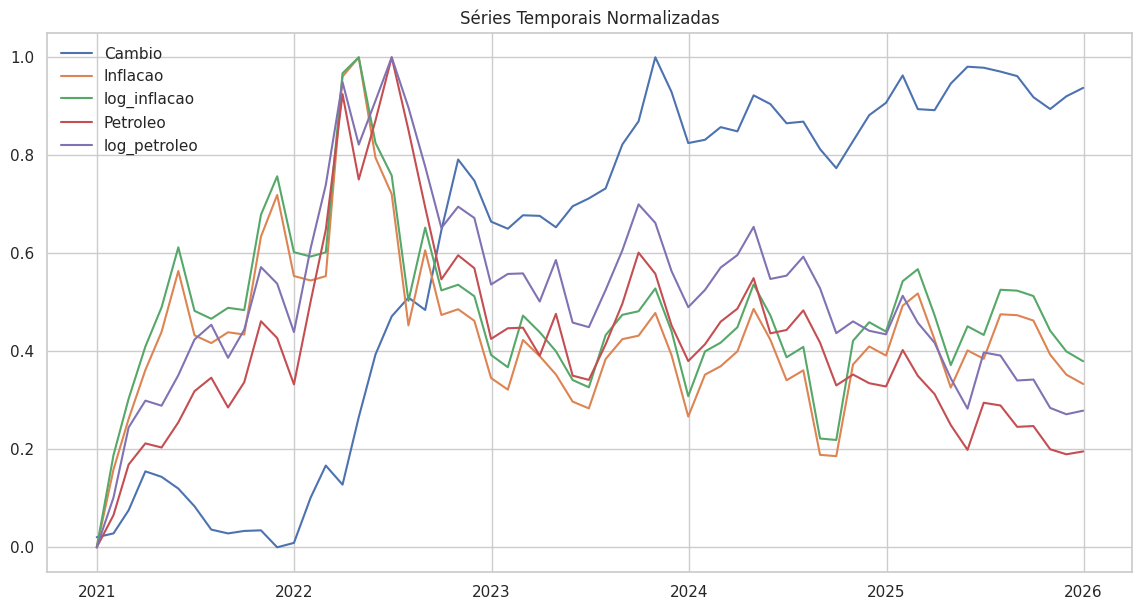


### DECOMPOSIÇÃO DA SÉRIE — Cambio ###


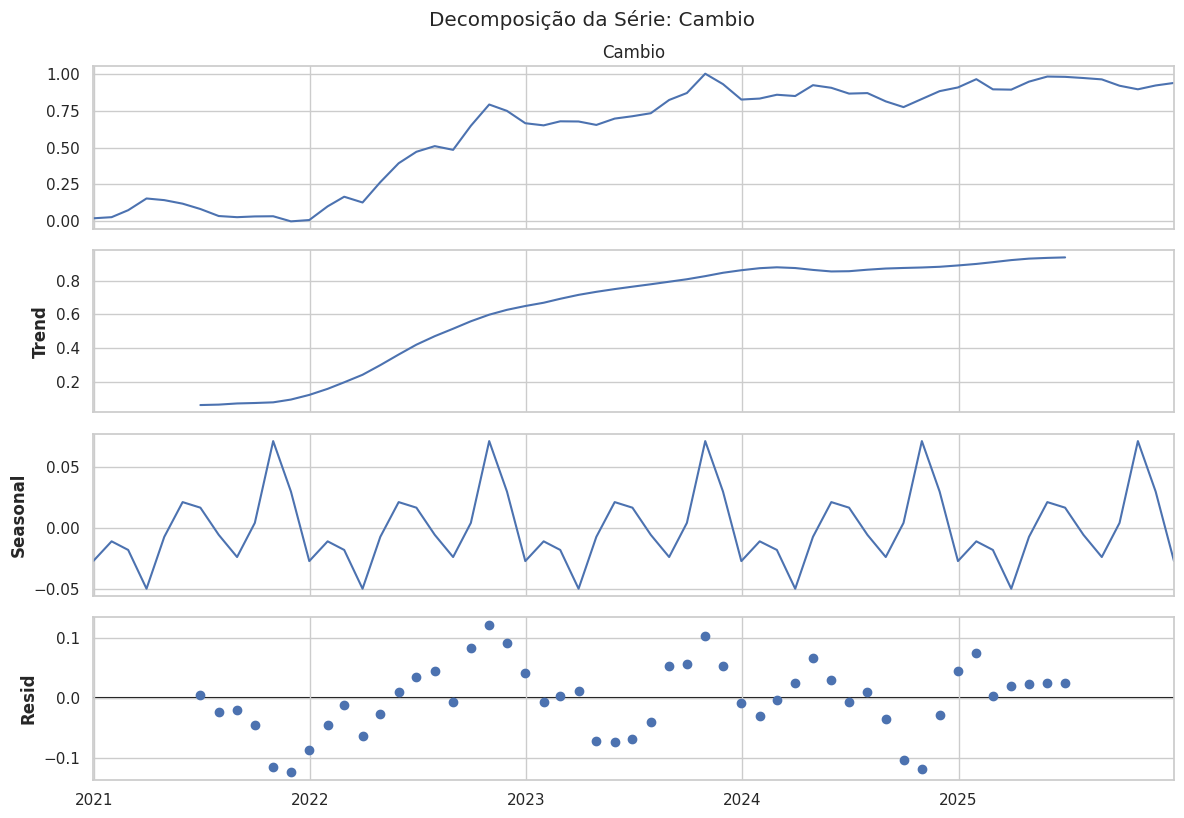


### DECOMPOSIÇÃO DA SÉRIE — Inflacao ###


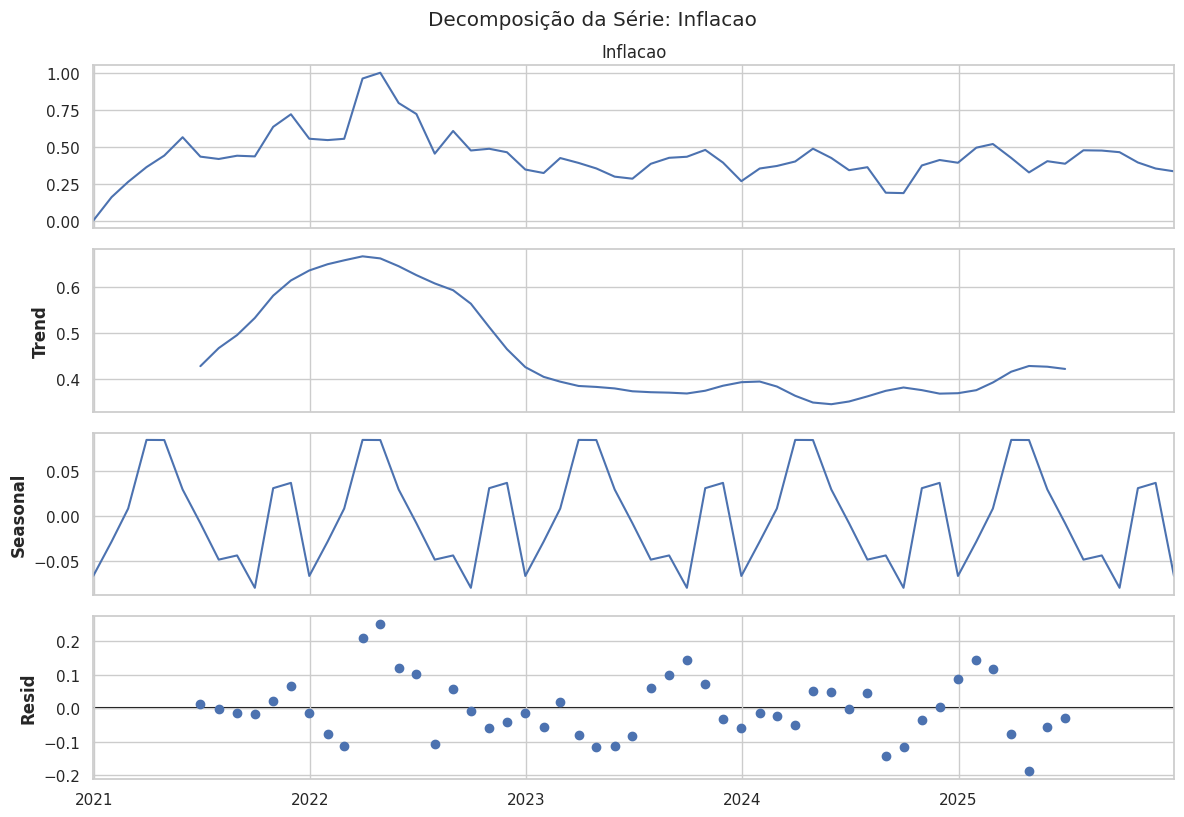


### DECOMPOSIÇÃO DA SÉRIE — log_inflacao ###


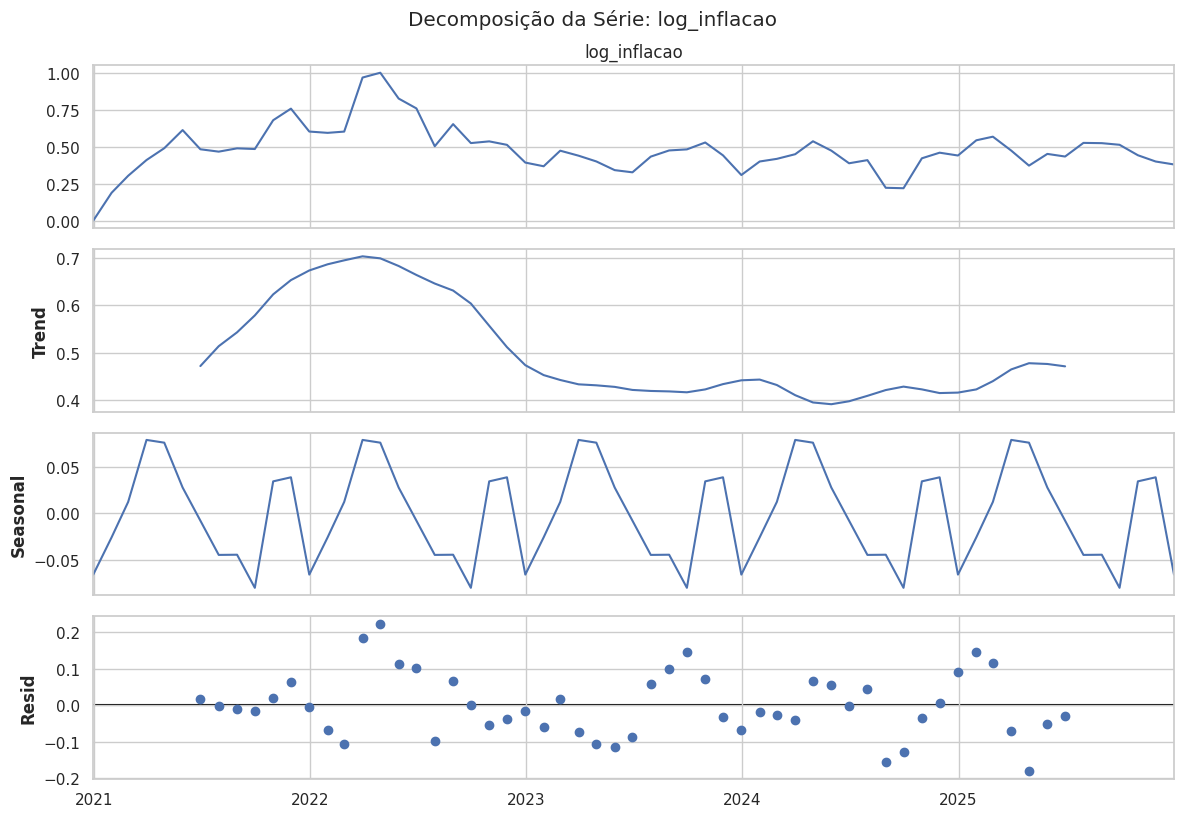


### DECOMPOSIÇÃO DA SÉRIE — Petroleo ###


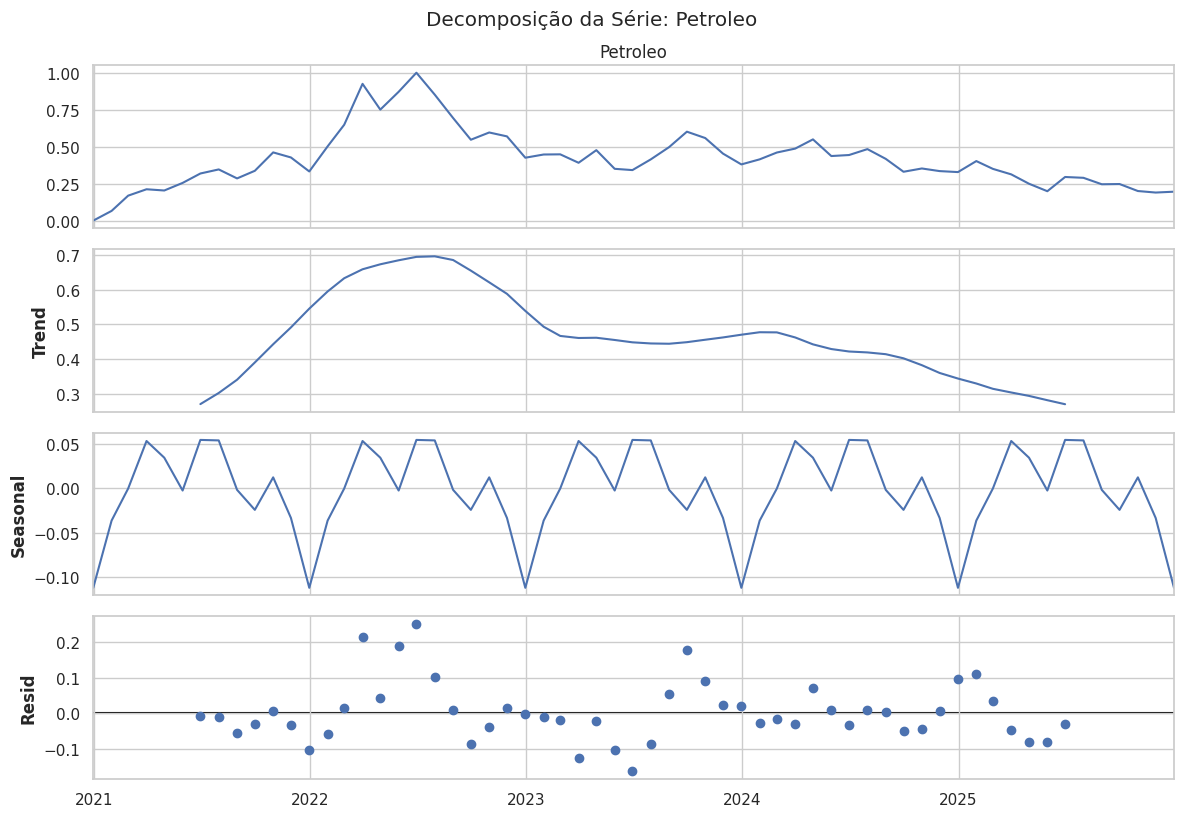


### DECOMPOSIÇÃO DA SÉRIE — log_petroleo ###


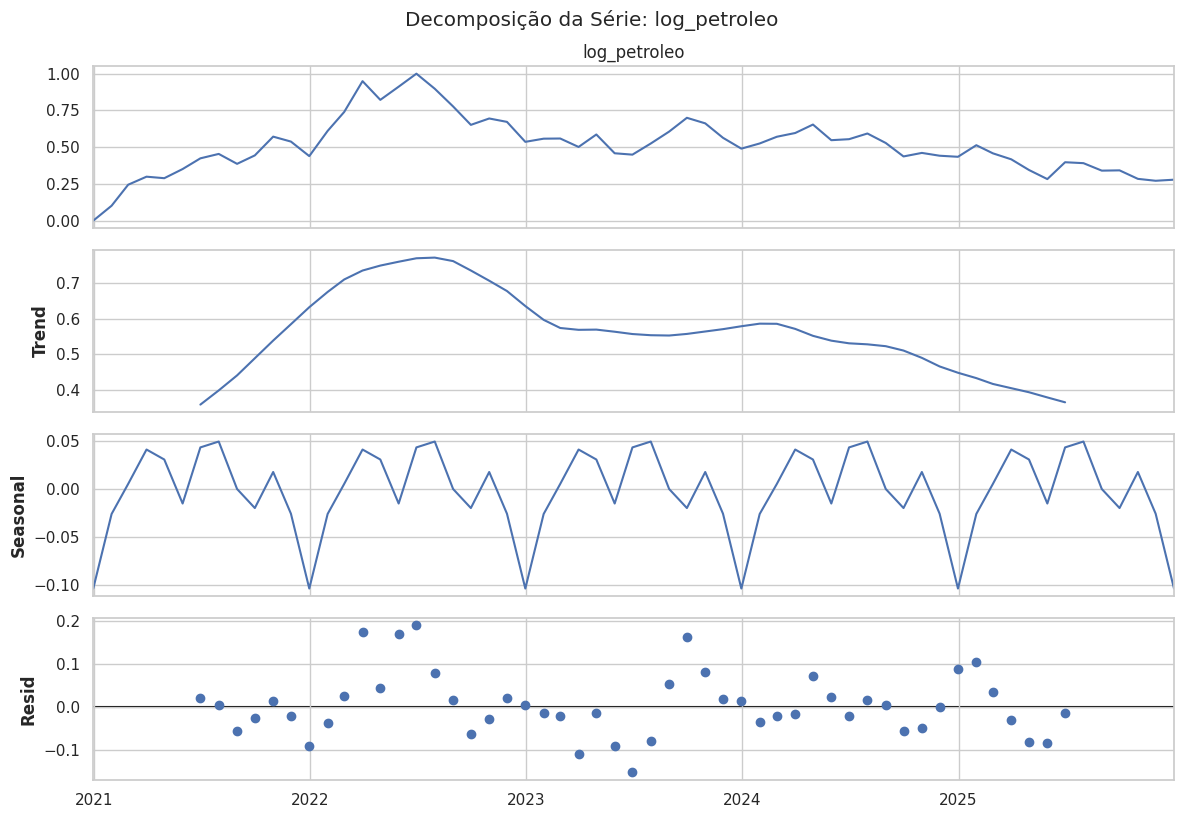

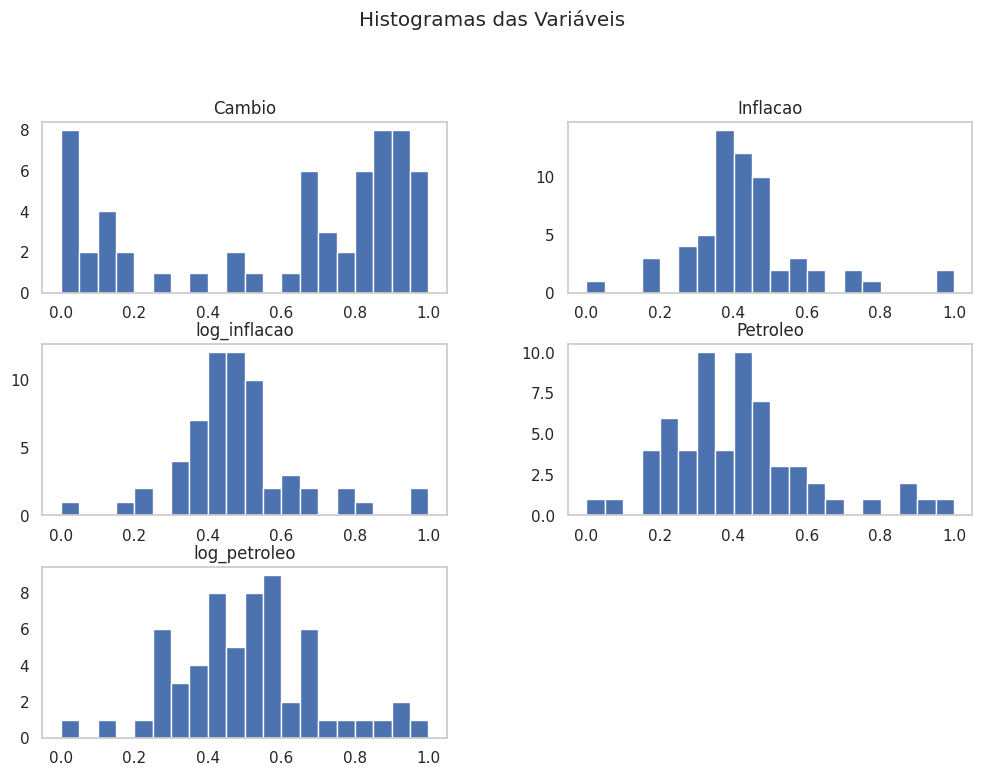

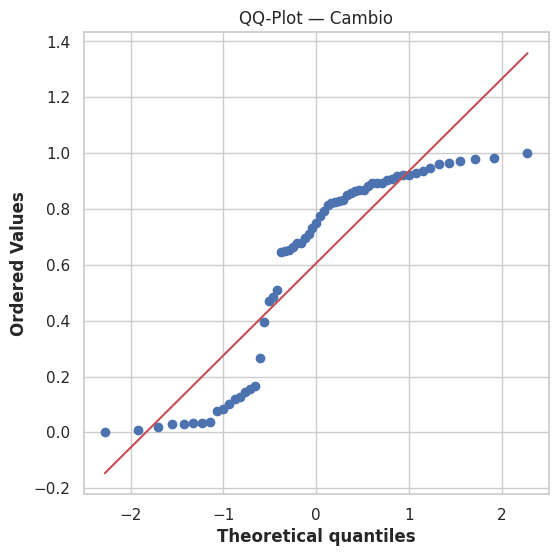

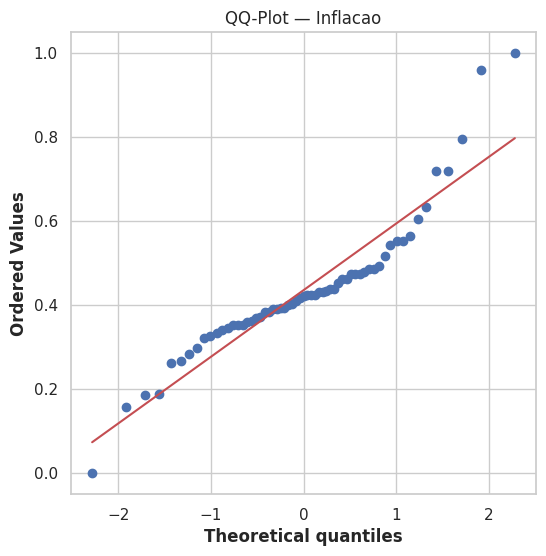

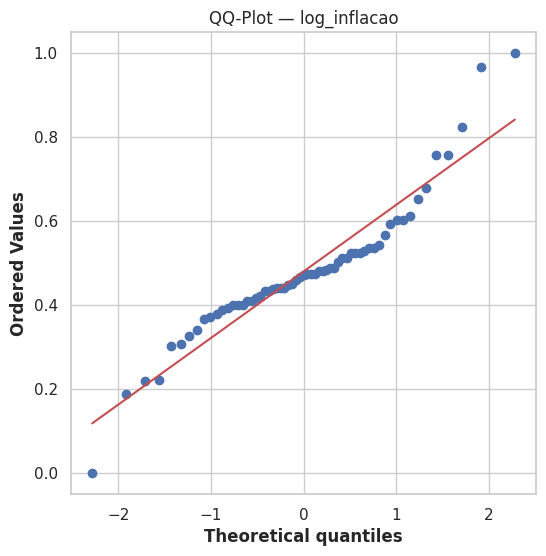

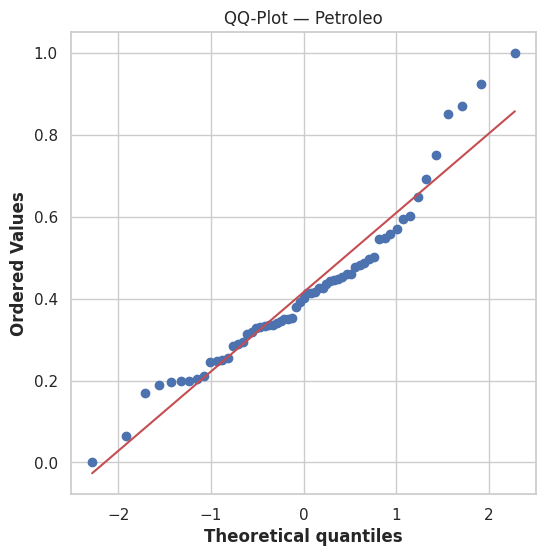

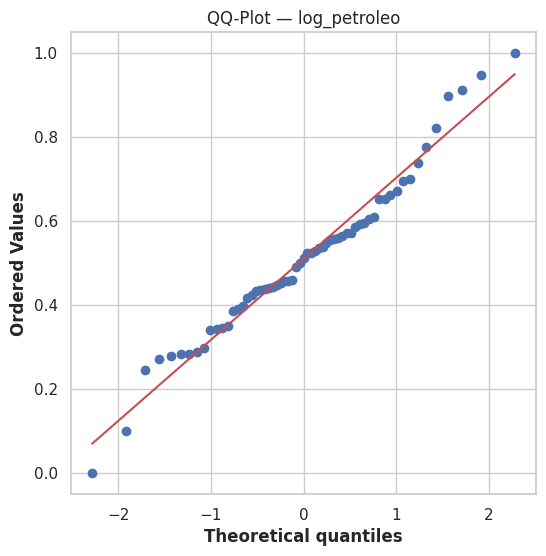

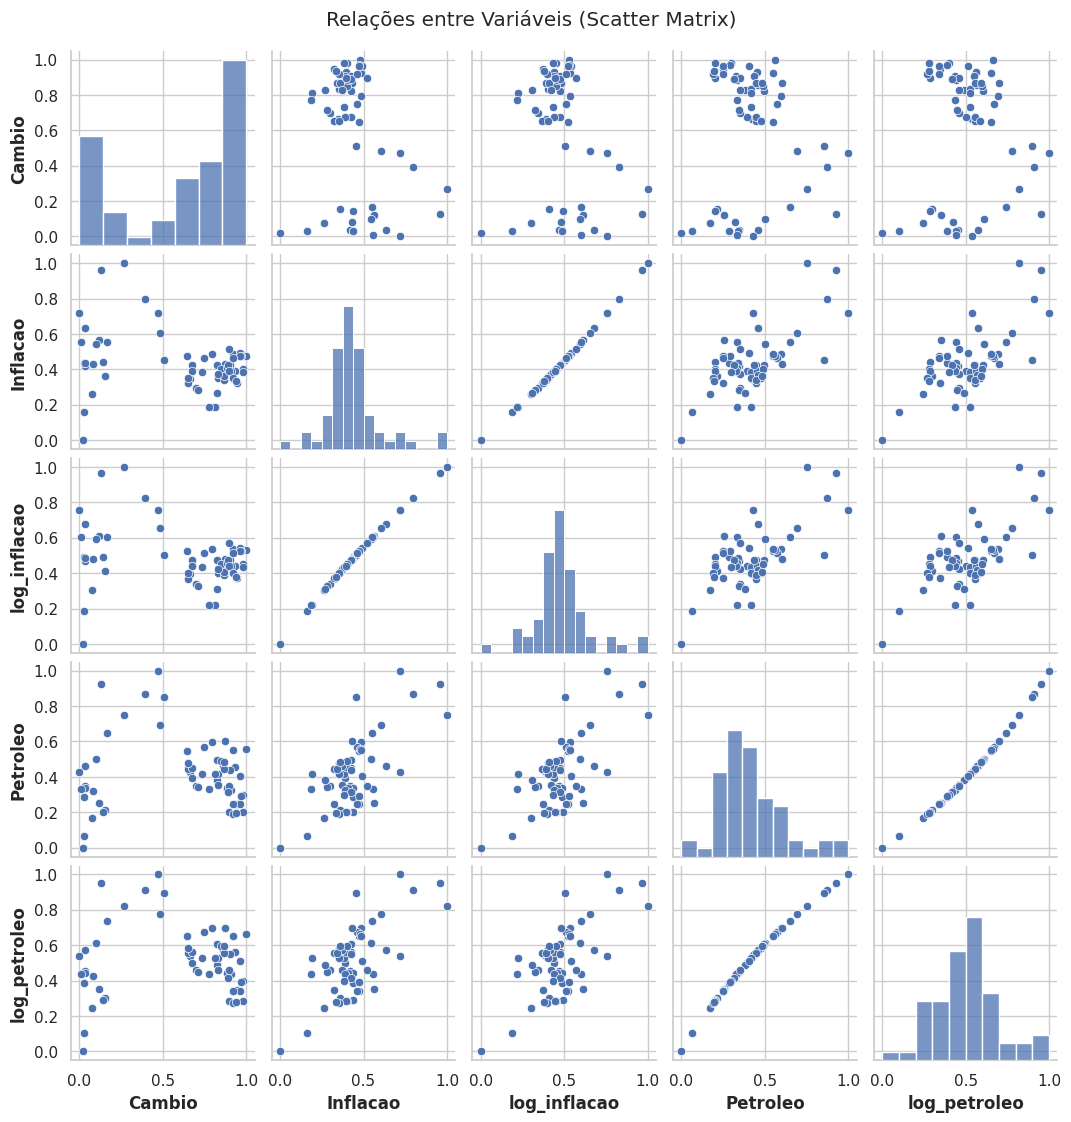

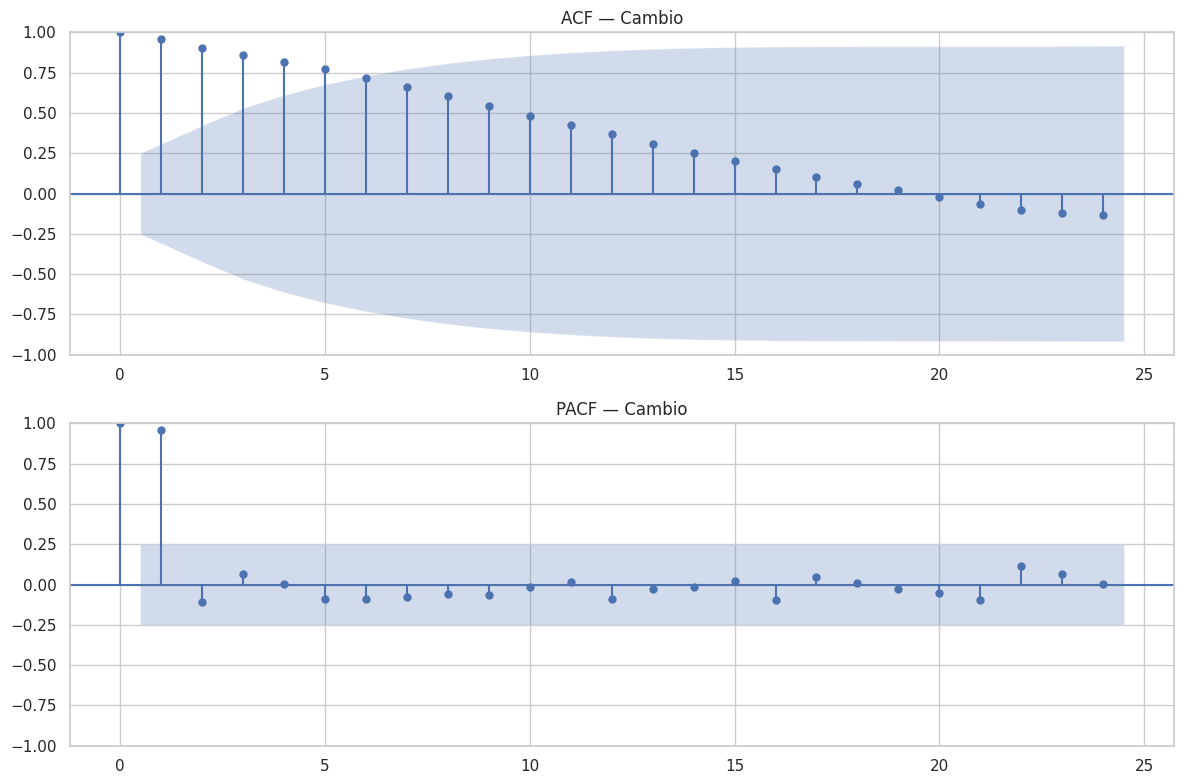

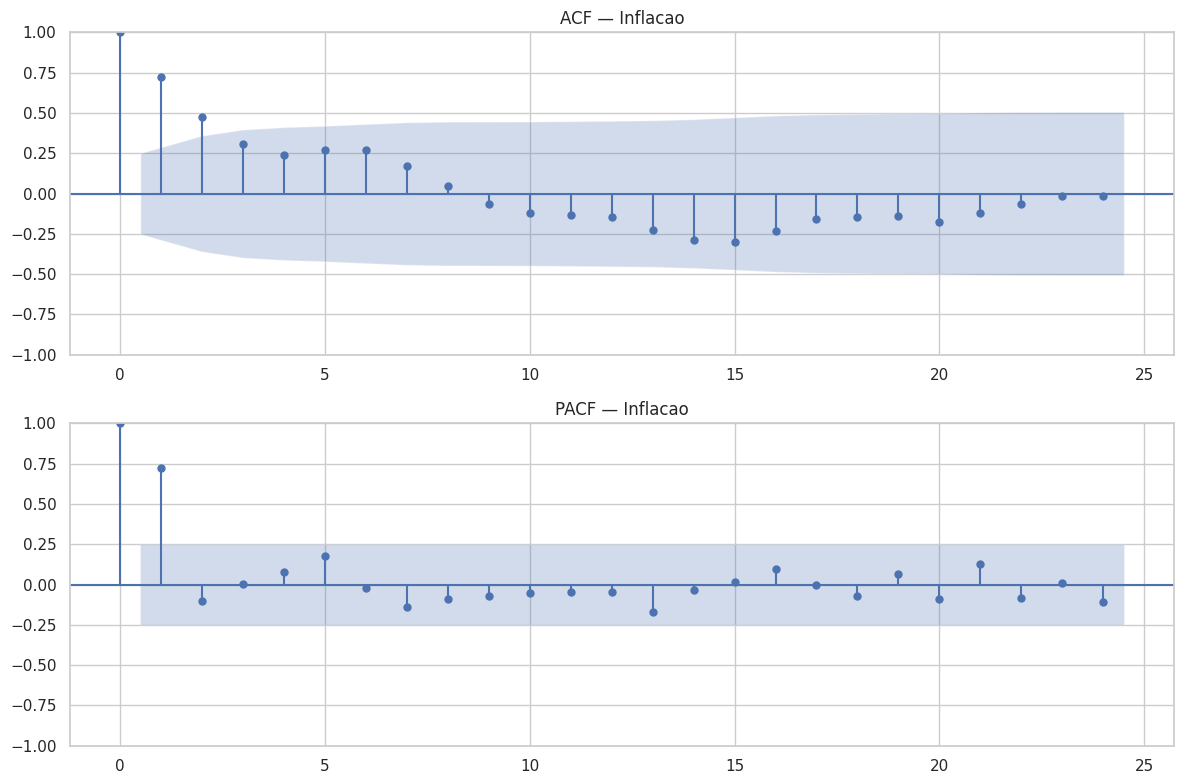

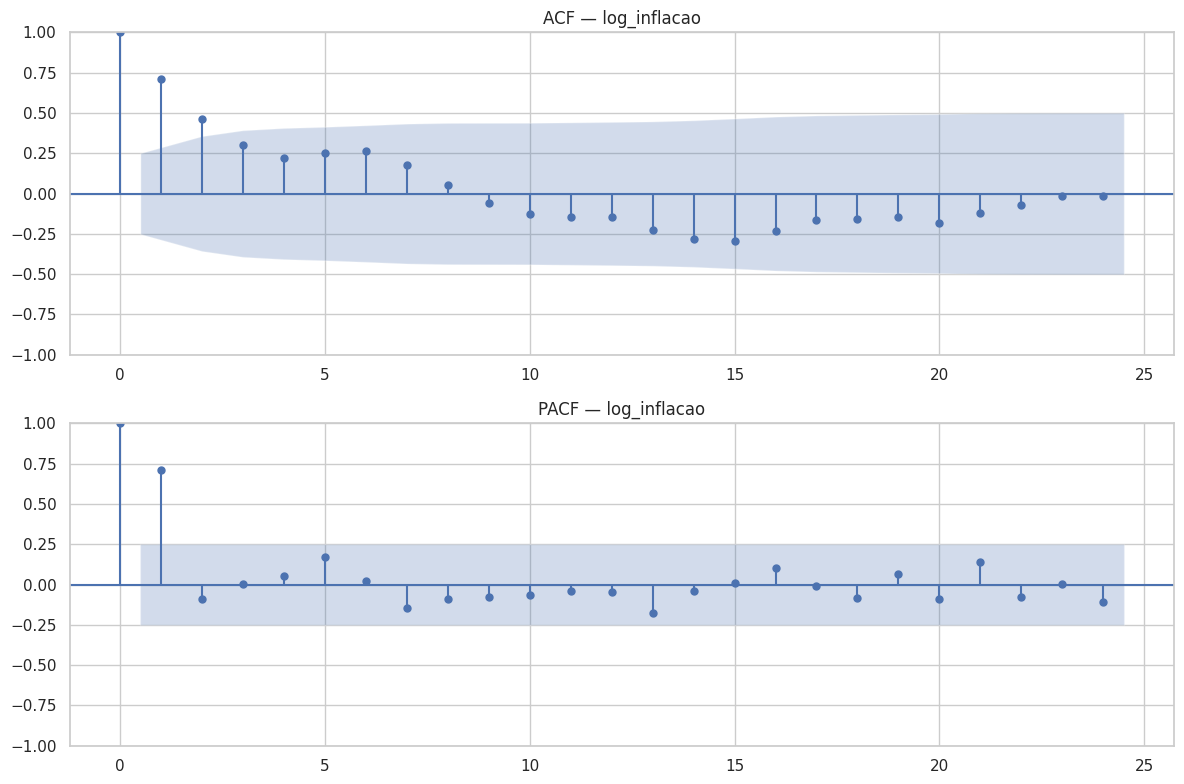

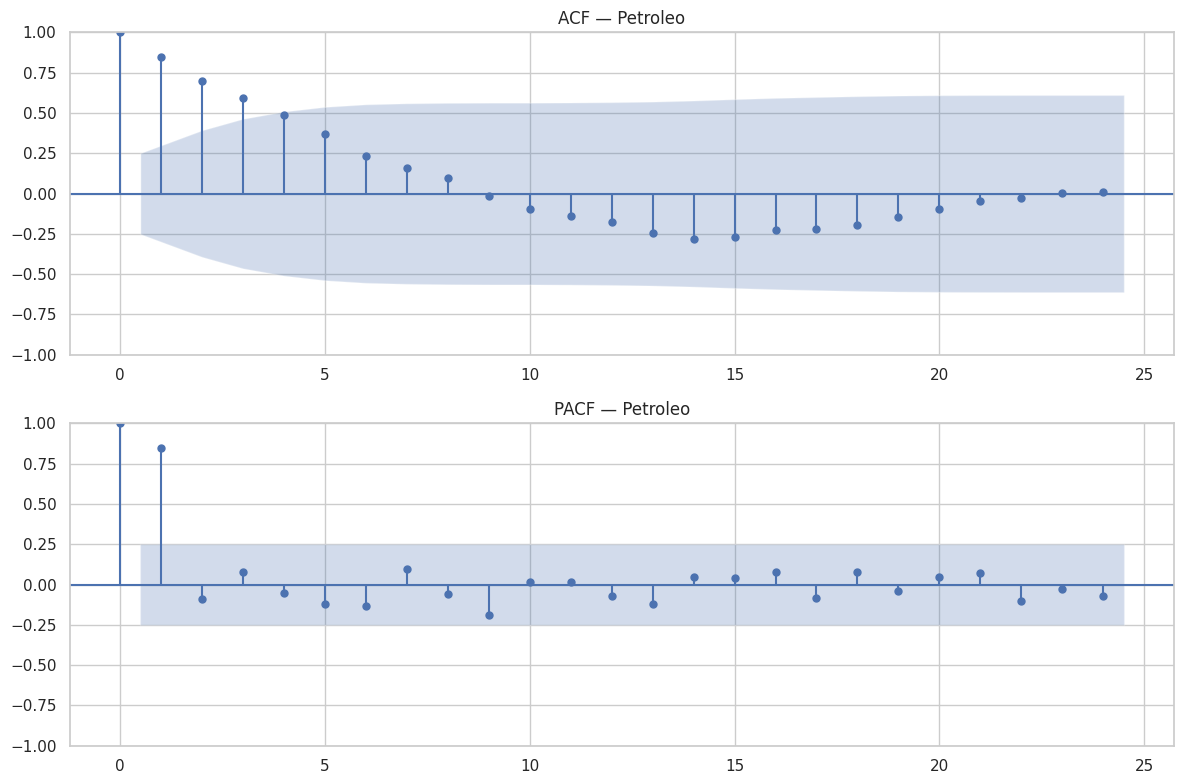

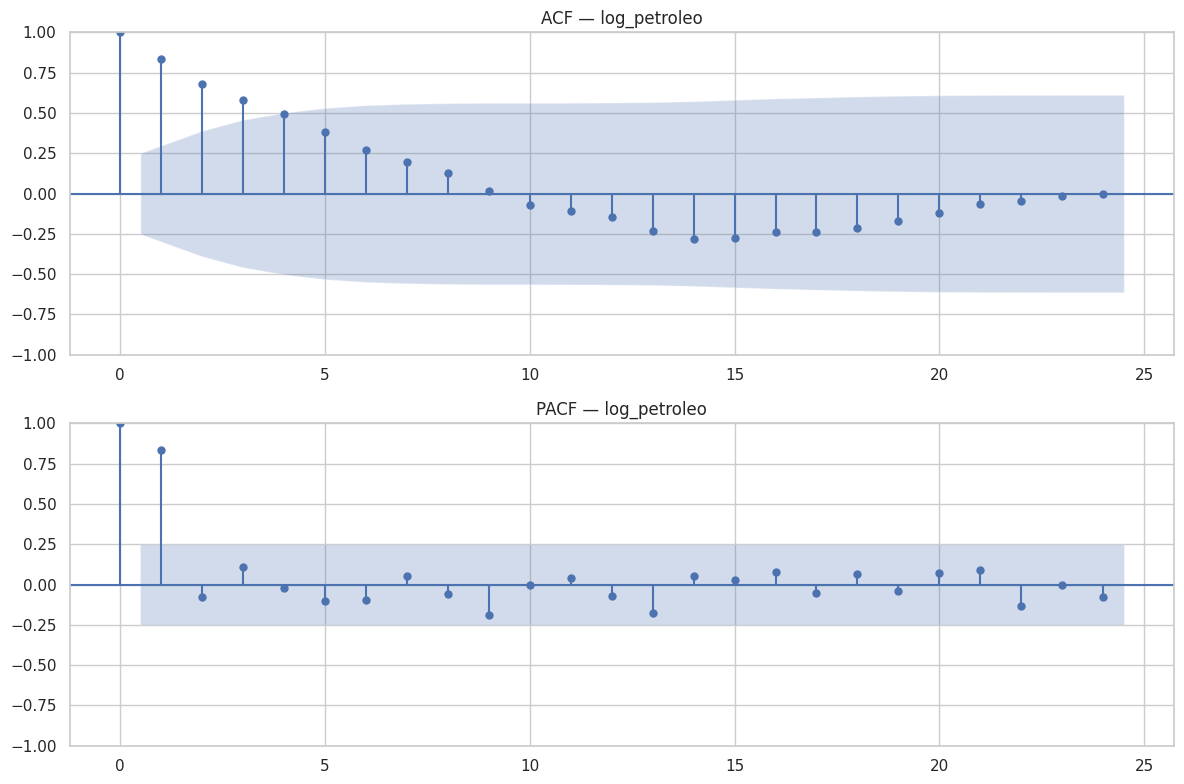

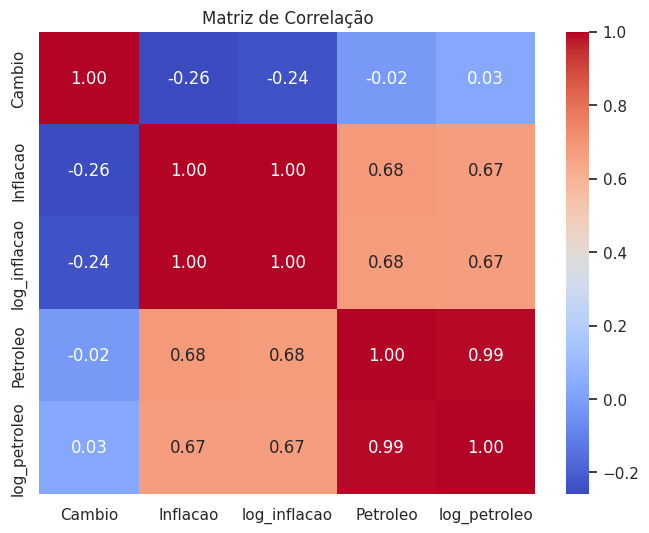


📌 ESTATÍSTICAS DESCRITIVAS
          Cambio   Inflacao  log_inflacao   Petroleo  log_petroleo
count  61.000000  61.000000     61.000000  61.000000     61.000000
mean    0.605679   0.435819      0.480396   0.415862      0.510409
std     0.352506   0.164982      0.163005   0.195682      0.191357
min     0.000000   0.000000      0.000000   0.000000      0.000000
25%     0.166828   0.352725      0.400133   0.294993      0.397611
50%     0.748237   0.423149      0.472860   0.402611      0.513366
75%     0.894206   0.478187      0.528255   0.487021      0.596423
max     1.000000   1.000000      1.000000   1.000000      1.000000


In [ ]:
# -------------------------------------------------------------
# 1. IMPORTAR BIBLIOTECAS
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as stats

sns.set(style="whitegrid")

variaveis = df_scaled.columns  # Lista automática das variáveis


# -------------------------------------------------------------
# 2. GRÁFICOS DAS SÉRIES TEMPORAIS (TODAS)
# -------------------------------------------------------------
plt.figure(figsize=(14, 7))
for col in variaveis:
    plt.plot(df_scaled.index, df_scaled[col], label=col)
plt.title("Séries Temporais Normalizadas")
plt.legend()
plt.show()


# -------------------------------------------------------------
# 3. DECOMPOSIÇÃO DAS SÉRIES (TODAS)
# -------------------------------------------------------------
for col in variaveis:
    print(f"\n### DECOMPOSIÇÃO DA SÉRIE — {col} ###")
    decomp = seasonal_decompose(df_scaled[col], model='additive', period=12)
    plt.rcParams["figure.figsize"] = (12, 8)
    decomp.plot()
    plt.suptitle(f"Decomposição da Série: {col}", y=1.02)
    plt.show()


# -------------------------------------------------------------
# 4. HISTOGRAMAS (TODOS)
# -------------------------------------------------------------
df_scaled.hist(figsize=(12, 8), bins=20, grid=False)
plt.suptitle("Histogramas das Variáveis", y=1.02)
plt.show()


# -------------------------------------------------------------
# 5. QQ-PLOTS (TODOS)
# -------------------------------------------------------------
for col in variaveis:
    plt.figure(figsize=(6, 6))
    stats.probplot(df_scaled[col], dist="norm", plot=plt)
    plt.title(f"QQ-Plot — {col}")
    plt.show()


# -------------------------------------------------------------
# 6. RELAÇÃO ENTRE VARIÁVEIS (SCATTER MATRIX)
# -------------------------------------------------------------
sns.pairplot(df_scaled, height=2.2)
plt.suptitle("Relações entre Variáveis (Scatter Matrix)", y=1.02)
plt.show()


# -------------------------------------------------------------
# 7. ACF e PACF (TODOS)
# -------------------------------------------------------------
for col in variaveis:
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(df_scaled[col], ax=ax[0], lags=24)
    plot_pacf(df_scaled[col], ax=ax[1], lags=24, method="ywm")
    ax[0].set_title(f"ACF — {col}")
    ax[1].set_title(f"PACF — {col}")
    plt.tight_layout()
    plt.show()


# -------------------------------------------------------------
# 8. MATRIZ DE CORRELAÇÃO
# -------------------------------------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(df_scaled.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()


# -------------------------------------------------------------
# 9. ESTATÍSTICAS DESCRITIVAS (TODAS)
# -------------------------------------------------------------
print("\n📌 ESTATÍSTICAS DESCRITIVAS")
print(df_scaled.describe())


# 4.1. Explicação do resultados de AED

Conforme o resumo que lhe forneci anteriormente, a Análise Exploratória de Dados (AED) é uma etapa fundamental. Vamos rever as principais conclusões e observações detalhadas, com base nos gráficos e estatísticas que foram gerados:

Análise Exploratória de Dados (AED): Principais Descobertas
Gráficos das Séries Temporais Normalizadas (Visualização Conjunta):

**Tendências Gerais**: As séries de 'Câmbio', 'Inflação' e 'Petróleo' (normalizadas entre 0 e 1) apresentaram tendências variadas ao longo do tempo. Observamos períodos de movimentos coordenados, onde todas as variáveis pareciam subir ou descer juntas, e também momentos de divergência, onde algumas variáveis mostravam tendências opostas.
**Volatilidade Comparativa**: A visualização conjunta destacou as diferenças de volatilidade, mesmo após a normalização. Algumas séries exibem flutuações mais acentuadas e frequentes que outras.
### Decomposição das Séries Temporais (Individualmente para todas as variáveis):

A decomposição de cada série ('Cambio', 'Inflacao', 'log_inflacao', 'Petroleo', 'log_petroleo') em tendência, sazonalidade e resíduos revelou padrões distintos. Para a 'Inflação' e 'log_inflacao', por exemplo, é possível observar uma tendência de longo prazo e um componente sazonal que se repete a cada 12 meses, sugerindo influências anuais. As componentes sazonais para as outras séries podem ser menos pronunciadas ou de natureza diferente.
Os resíduos (componente irregular) representam o que não foi explicado pela tendência e sazonalidade. Resíduos aleatórios indicam uma boa captura da estrutura base da série.

### Histogramas das Variáveis (Individualmente para todas as variáveis):

Os histogramas das variáveis normalizadas revelam suas distribuições de frequência. A maioria das distribuições não parece ser perfeitamente normal, apresentando assimetrias e, em alguns casos, multimodalidade (múltiplos picos), como pode ser o caso para 'Câmbio' ou 'Petróleo', sugerindo diferentes regimes de comportamento.
A 'Inflação' e 'log_inflacao' tendem a ter distribuições mais concentradas, indicando menor variabilidade em comparação com o 'Câmbio' ou 'Petróleo'.

### QQ-Plots (Individualmente para todas as variáveis):

Os QQ-plots comparam a distribuição de cada variável com uma distribuição normal teórica. Desvios significativos da linha de 45 graus, especialmente nas caudas, indicam não-normalidade. É comum em dados financeiros e económicos observar 'caudas pesadas' (fat tails), ou seja, a ocorrência de valores extremos é mais frequente do que numa distribuição normal.

### Matriz de Dispersão (Scatter Matrix):

Esta matriz visualiza as relações entre cada par de variáveis. Observamos padrões que variam de nuvens de pontos mais dispersas (sugerindo pouca ou nenhuma correlação linear) a concentrações que indicam correlações lineares ou não lineares. A presença de outliers (pontos isolados) também pode ser identificada, que podem influenciar a modelagem.
### ACF e PACF (Individualmente para todas as variáveis):

Os gráficos da Função de Autocorrelação (**ACF**) e da Função de Autocorrelação Parcial (**PACF**) para cada variável revelam a extensão da dependência temporal. Picos significativos nos primeiros lags da ACF e um decaimento lento podem indicar não-estacionariedade e a necessidade de diferenciação. Os padrões na PACF ajudam a identificar a ordem das componentes autorregressivas (AR) e de média móvel (MA) para modelos ARIMA e VAR.

### Matriz de Correlação:

A matriz de correlação (heatmap) quantifica as relações lineares. Observamos correlações positivas entre todas as variáveis, com destaque para:
**Inflação vs. log_inflacao**: Correlação de 0.99, o que é esperado, pois 'log_inflacao' é a transformação logarítmica da 'Inflação'.
Petroleo vs. log_petroleo: Correlação de 0.99, também esperado.
**Inflação vs. Petroleo**: Correlação de 0.86, indicando uma forte relação linear positiva.
**Câmbio vs. Inflação**: Correlação de 0.78, também uma forte relação linear positiva.
Câmbio vs. Petroleo: Correlação de 0.65, uma correlação positiva moderada.
Estas correlações sugerem uma interdependência significativa entre os indicadores económicos, o que pode ser explorado em modelos multivariados como o VAR.

### Estatísticas Descritivas:

O .describe() para df_scaled fornece um resumo numérico. Por exemplo, o 'Câmbio' tem uma média de 0.605 e um desvio padrão de 0.352, sendo a variável mais volátil. A 'Inflação' (média 0.435, std 0.164) é a menos volátil, e o 'Petróleo' (média 0.415, std 0.195) apresenta volatilidade intermédia. A diferença entre a média e a mediana (50%) pode indicar assimetria nas distribuições, conforme observado nos histogramas.
Próximos Passos:
Com estas descobertas, estamos agora preparados para avançar para as etapas de modelagem, onde exploraremos modelos de previsão de séries temporais que possam capturar estas tendências, sazonalidades e interdependências. A estacionariedade e a necessidade de lidar com distribuições não-normais serão considerações importantes na escolha e aplicação dos modelos.



# 5. Testes de Estacionaridade e Diferenciação

In [ ]:
# -------------------------------------------------------------
# 1. IMPORTAR BIBLIOTECAS
# -------------------------------------------------------------
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np

# Selecionar somente as variáveis originais (não logs)
variaveis_originais = ["Cambio", "Inflacao", "Petroleo"]

# Lista para armazenar os resultados de cada linha
resultados_list = []

# -------------------------------------------------------------
# 2. FUNÇÕES AUXILIARES
# -------------------------------------------------------------
def teste_adf(series):
    return adfuller(series, autolag='AIC')[1]  # Retorna p-value

def teste_kpss(series):
    # Retorna p-value
    try:
        return kpss(series, regression='c', nlags="auto")[1]
    except:
        return np.nan

# -------------------------------------------------------------
# 3. LOOP PARA TODAS AS VARIÁVEIS
# -------------------------------------------------------------
df_stationary = df_scaled.copy()  # Copia para criar séries estacionárias

for var in variaveis_originais:
    series = df_scaled[var]

    p_adf  = teste_adf(series)
    p_kpss = teste_kpss(series)

    estacionaria = "Sim" if (p_adf < 0.05 and p_kpss > 0.05) else "Não"

    diferenca = 0
    # Se não for estacionária, aplicar diferenciação
    if estacionaria == "Não":
        series_diff = series.diff().dropna()
        # Certifica-se de que a série diferenciada tem o mesmo índice para evitar problemas de alinhamento
        df_stationary.loc[series_diff.index, var] = series_diff
        diferenca = 1
        # Recalcular testes após diferenciação
        p_adf  = teste_adf(series_diff)
        p_kpss = teste_kpss(series_diff)
        estacionaria = "Sim" if (p_adf < 0.05 and p_kpss > 0.05) else "Não"

    resultados_list.append({
        "Variável": var,
        "ADF_pvalue": round(p_adf,4),
        "KPSS_pvalue": round(p_kpss,4),
        "Estacionária": estacionaria,
        "Diferençada": diferenca
    })

# Converter a lista de resultados em DataFrame
resultados = pd.DataFrame(resultados_list)

# -------------------------------------------------------------
# 4. RESULTADOS
# -------------------------------------------------------------
print("\n Testes de Estacionaridade e Diferenciação")
print(resultados)

print("\n Dataset após diferenciação (se necessário)")
print(df_stationary.head())


📌 Testes de Estacionaridade e Diferenciação
   Variável  ADF_pvalue  KPSS_pvalue Estacionária  Diferençada
0    Cambio      0.0000          0.1          Sim            1
1  Inflacao      0.0091          0.1          Sim            0
2  Petroleo      0.0000          0.1          Sim            1

📌 Dataset após diferenciação (se necessário)
              Cambio  Inflacao  log_inflacao  Petroleo  log_petroleo
date                                                                
2020-12-31  0.020635  0.000000      0.000000  0.000000      0.000000
2021-01-31  0.007734  0.158888      0.188236  0.065739      0.101700
2021-02-28  0.047258  0.262055      0.303255  0.103173      0.244659
2021-03-31  0.079357  0.361863      0.409691  0.043092      0.299330
2021-04-30 -0.011192  0.439775      0.489725 -0.008299      0.289007


# 6. Divisão de Dados de Treino vs. Teste (80% vs. 20%)


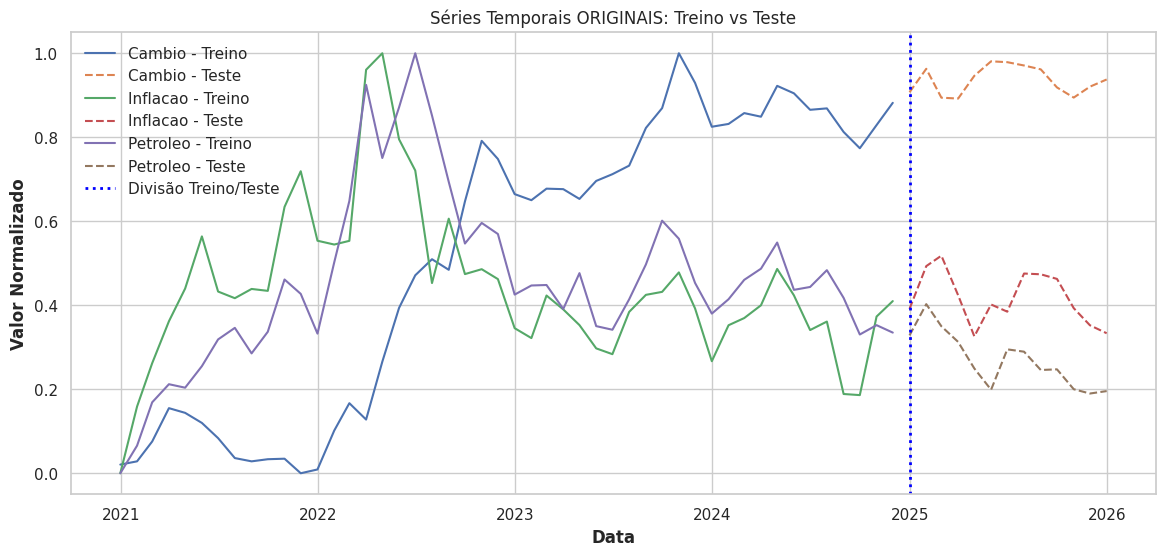

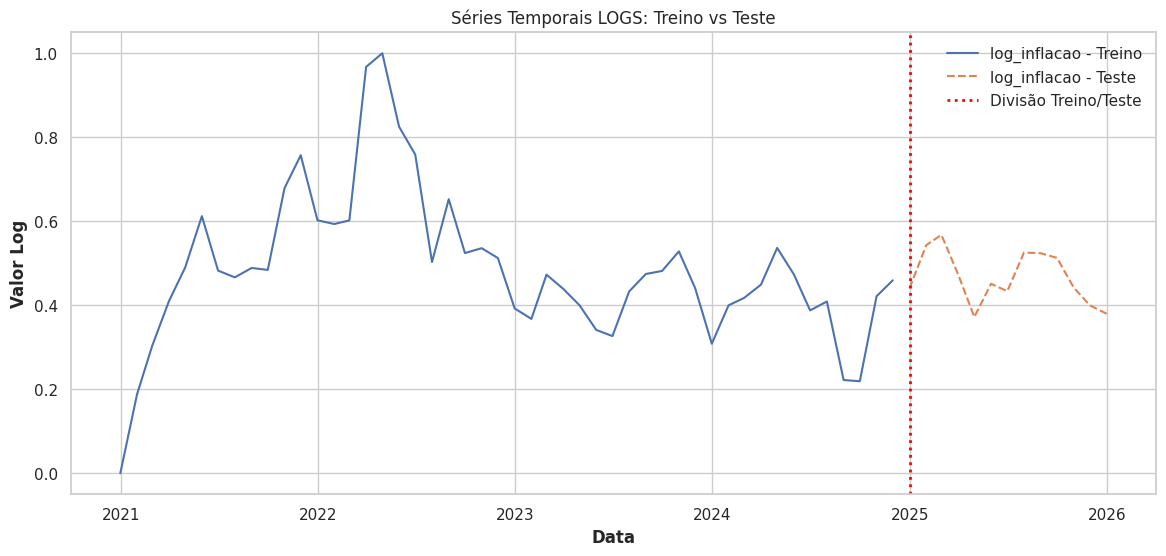

In [ ]:
# -------------------------------------------------------------
# 1. IMPORTAR BIBLIOTECAS
# -------------------------------------------------------------
import matplotlib.pyplot as plt

df_data = df_scaled.copy()  # ou df_stationary se preferir

# Separar variáveis originais e logs
variaveis_originais = ["Cambio", "Inflacao", "Petroleo"]
variaveis_logs      = ["log_inflacao", "log_pib"]  # Ajustar conforme dataset

# -------------------------------------------------------------
# 2. DIVISÃO TREINO / TESTE (80% / 20%)
# -------------------------------------------------------------
tamanho_treino = int(len(df_data) * 0.8)
train = df_data.iloc[:tamanho_treino]
test  = df_data.iloc[tamanho_treino:]

linha_divisao = df_data.index[tamanho_treino]  # posição da linha vertical

# -------------------------------------------------------------
# 3. GRÁFICOS DAS VARIÁVEIS ORIGINAIS
# -------------------------------------------------------------
plt.figure(figsize=(14, 6))
for col in variaveis_originais:
    plt.plot(train.index, train[col], label=f"{col} - Treino")
    plt.plot(test.index, test[col], label=f"{col} - Teste", linestyle="--")

# Linha vertical para divisão treino/teste
plt.axvline(x=linha_divisao, color='blue', linestyle=':', linewidth=2, label="Divisão Treino/Teste")

plt.title("Séries Temporais ORIGINAIS: Treino vs Teste")
plt.xlabel("Data")
plt.ylabel("Valor Normalizado")
plt.legend()
plt.show()

# -------------------------------------------------------------
# 4. GRÁFICOS DAS VARIÁVEIS LOG
# -------------------------------------------------------------
plt.figure(figsize=(14, 6))
for col in variaveis_logs:
    if col in df_data.columns:
        plt.plot(train.index, train[col], label=f"{col} - Treino")
        plt.plot(test.index, test[col], label=f"{col} - Teste", linestyle="--")

# Linha vertical para divisão treino/teste
plt.axvline(x=linha_divisao, color='red', linestyle=':', linewidth=2, label="Divisão Treino/Teste")

plt.title("Séries Temporais LOGS: Treino vs Teste")
plt.xlabel("Data")
plt.ylabel("Valor Log")
plt.legend()
plt.show()




# 7. Estimação dos Modelos
#### Séries Temporais
*   ARIAM
*   GARCH
#### Machine Learning
*   XBoost
*   Random Forest
#### Deep Learning
*   LSTM
*   GRU


In [ ]:
# =============================================================
# ESTIMAÇÃO COMPLETA: ARIMA, GARCH, RandomForest, XGBoost, LSTM, GRU
# - Seleção por AIC/BIC (ARIMA/GARCH)
# - Validação cruzada temporal (TimeSeriesSplit) para ML
# - Hiper-tuning LSTM/GRU via Optuna (com TimeSeriesSplit interno)
# - Output: melhores parâmetros e RMSE (CV)
# =============================================================

# -------------------------------------------------------------
# 0. INSTALAR (se necessário) - execute uma vez no Colab
# -------------------------------------------------------------
# !pip install optuna xgboost arch

# -------------------------------------------------------------
# 1. IMPORTAR BIBLIOTECAS
# -------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import optuna
import time
import json
import pandas as pd

# -------------------------------------------------------------
# 2. PARÂMETROS GERAIS E DADOS (ajusta target se necessário)
# -------------------------------------------------------------
# Assumimos df_scaled já no ambiente (index datetime)
df = df_scaled.copy()   # dados normalizados (úteis para ML/DL)
target = "Inflacao"     # alterar se necessário

# Divisão treino/teste (80/20) usada mais tarde para forecasts finais
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df  = df.iloc[train_size:]

# Função RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# TimeSeriesSplit (para CV)
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# -------------------------------------------------------------
# 3. ARIMA: seleção automática por AIC/BIC e validação resíduos
# -------------------------------------------------------------
print(">>> 3. Seleção ARIMA por AIC/BIC e validação de resíduos")

y = df[target]

p_range = range(0, 4)
d_range = range(0, 2)
q_range = range(0, 4)

best_aic = np.inf
best_bic = np.inf
best_order_aic = None
best_order_bic = None

start_time = time.time()
for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                model = ARIMA(train_df[target], order=(p,d,q))
                res = model.fit()
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_order_aic = (p,d,q)
                if res.bic < best_bic:
                    best_bic = res.bic
                    best_order_bic = (p,d,q)
            except Exception:
                continue

print(f"Melhor ARIMA por AIC: order={best_order_aic} AIC={best_aic:.3f}")
print(f"Melhor ARIMA por BIC: order={best_order_bic} BIC={best_bic:.3f}")
print("Tempo ARIMA search: %.1f s" % (time.time()-start_time))

# Estimar ARIMA final (usar ordem por AIC)
arima_final = ARIMA(train_df[target], order=best_order_aic).fit()
print(arima_final.summary())

# Validar resíduos do ARIMA
resid = arima_final.resid.dropna()
# Ljung-Box (lags 12)
lb = acorr_ljungbox(resid, lags=[12], return_df=True)
shap_p = shapiro(resid)[1]
print("\nARIMA - Ljung-Box p-value (lag 12):", lb['lb_pvalue'].values[0])
print("ARIMA - Shapiro p-value (normalidade):", shap_p)

# -------------------------------------------------------------
# 4. GARCH: seleção automática por AIC/BIC e validação resíduos
# -------------------------------------------------------------
print("\n>>> 4. Seleção GARCH por AIC/BIC e validação de resíduos")
# Para GARCH, normalmente modelamos retornos ou séries sem tendência.
# Aqui aplicamos diretamente ao target (assume já transformado se necessário)
pq_candidates = [(1,1),(1,2),(2,1),(2,2),(3,1),(1,3)]
best_garch_aic = np.inf
best_garch_bic = np.inf
best_garch_params_aic = None
best_garch_params_bic = None

start_time = time.time()
for p,q in pq_candidates:
    try:
        gm = arch_model(train_df[target], vol='Garch', p=p, q=q, rescale=False)
        gf = gm.fit(disp='off')
        if gf.aic < best_garch_aic:
            best_garch_aic = gf.aic
            best_garch_params_aic = (p,q)
        if gf.bic < best_garch_bic:
            best_garch_bic = gf.bic
            best_garch_params_bic = (p,q)
    except Exception:
        continue

print(f"Melhor GARCH por AIC: p,q={best_garch_params_aic} AIC={best_garch_aic:.3f}")
print(f"Melhor GARCH por BIC: p,q={best_garch_params_bic} BIC={best_garch_bic:.3f}")
print("Tempo GARCH search: %.1f s" % (time.time()-start_time))

# Estimar GARCH final (usar params por AIC)
garch_final = arch_model(train_df[target], vol='Garch', p=best_garch_params_aic[0], q=best_garch_params_aic[1], rescale=False).fit(disp='off')
print(garch_final.summary())

# Resíduos GARCH (standardized residuals)
garch_resid = garch_final.std_resid.dropna()
lb_g = acorr_ljungbox(garch_resid, lags=[12], return_df=True)
shap_g_p = shapiro(garch_resid)[1]
print("\nGARCH - Ljung-Box p-value (lag 12):", lb_g['lb_pvalue'].values[0])
print("GARCH - Shapiro p-value (normalidade):", shap_g_p)

# -------------------------------------------------------------
# 5. MACHINE LEARNING: RandomizedSearchCV com TimeSeriesSplit
# -------------------------------------------------------------
print("\n>>> 5. Tuning RandomForest e XGBoost (RandomizedSearchCV com TimeSeriesSplit)")

X = df.drop(columns=[target])
y = df[target]

# Definir scorer (neg RMSE)
def neg_rmse_scorer(estimator, X_, y_):
    ypred = estimator.predict(X_)
    return -np.sqrt(mean_squared_error(y_, ypred))

scorer = make_scorer(lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=True)

# Random Forest param grid
rf_param_dist = {
    "n_estimators": [50,100,200,400],
    "max_depth": [3,5,8,12, None],
    "min_samples_split":[2,5,10],
    "min_samples_leaf":[1,2,4]
}

rf = RandomForestRegressor(random_state=42)
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_dist,
    n_iter=20,                 # diminui/incremente conforme tempo disponível
    scoring=scorer,
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
start_time = time.time()
rf_search.fit(X, y)
print("RandomForest best params:", rf_search.best_params_)
print("RandomForest best score (neg RMSE):", rf_search.best_score_)
print("Tempo RandomForest tuning: %.1f s" % (time.time()-start_time))

# XGBoost param grid
xgb_param_dist = {
    "n_estimators":[50,100,200],
    "learning_rate":[0.01,0.05,0.1,0.2],
    "max_depth":[3,4,6,8],
    "subsample":[0.6,0.8,1.0],
    "colsample_bytree":[0.6,0.8,1.0]
}

xgbr = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_search = RandomizedSearchCV(
    estimator=xgbr,
    param_distributions=xgb_param_dist,
    n_iter=20,
    scoring=scorer,
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
start_time = time.time()
xgb_search.fit(X, y)
print("XGBoost best params:", xgb_search.best_params_)
print("XGBoost best score (neg RMSE):", xgb_search.best_score_)
print("Tempo XGBoost tuning: %.1f s" % (time.time()-start_time))

# -------------------------------------------------------------
# 6. DEEP LEARNING: TUNING LSTM / GRU COM OPTUNA
# -------------------------------------------------------------
print("\n>>> 6. Tuning LSTM & GRU via Optuna (TimeSeriesSplit dentro do objetivo)")

# Função auxiliar para criar sequências multivariadas
def create_sequences_multivar(df_values, timesteps):
    Xs, ys = [], []
    for i in range(timesteps, len(df_values)):
        Xs.append(df_values[i-timesteps:i, :])
        ys.append(df_values[i, df_columns_index[target]])
    return np.array(Xs), np.array(ys)

# Preparar dados
df_values = df.values
df_columns = df.columns.tolist()
df_columns_index = {c:i for i,c in enumerate(df_columns)}

# Objective para Optuna
def objective_lstm(trial):
    # hyperparams
    timesteps = trial.suggest_int("timesteps", 1, 6)
    units = trial.suggest_categorical("units", [16,32,64,128])
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8,16,32])
    epochs = trial.suggest_int("epochs", 20, 80, step=10)
    rnn_type = trial.suggest_categorical("rnn_type", ["LSTM","GRU"])

    # criar X,y
    X_all, y_all = create_sequences_multivar(df_values, timesteps)

    # TimeSeriesSplit CV manual
    tscv_local = TimeSeriesSplit(n_splits=3)
    rmses = []
    for train_idx, val_idx in tscv_local.split(X_all):
        X_train_cv, X_val_cv = X_all[train_idx], X_all[val_idx]
        y_train_cv, y_val_cv = y_all[train_idx], y_all[val_idx]

        # construir modelo
        model = Sequential()
        if rnn_type=="LSTM":
            model.add(LSTM(units, input_shape=(X_train_cv.shape[1], X_train_cv.shape[2])))
        else:
            model.add(GRU(units, input_shape=(X_train_cv.shape[1], X_train_cv.shape[2])))
        if dropout>0:
            model.add(Dropout(dropout))
        model.add(Dense(1))
        model.compile(optimizer=Adam(lr), loss="mse")

        es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=0)
        model.fit(X_train_cv, y_train_cv, validation_data=(X_val_cv, y_val_cv),
                  epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=0)

        ypred = model.predict(X_val_cv).flatten()
        rmses.append(np.sqrt(mean_squared_error(y_val_cv, ypred)))
        # limpar sessão para não acumular GPU mem
        tf.keras.backend.clear_session()

    return np.mean(rmses)

# Rodar Optuna
n_trials = 20   # ajustar para mais (ex: 50) se tiver tempo/GPU
study = optuna.create_study(direction="minimize")
start_time = time.time()
study.optimize(objective_lstm, n_trials=n_trials, timeout=None)
print("Tempo Optuna:", time.time()-start_time)
print("Melhores parâmetros Optuna:", study.best_params)
print("Melhor RMSE (CV) Optuna:", study.best_value)

# Extrair parametros e treinar modelo final com todos os dados de treino
best = study.best_params
timesteps_best = best["timesteps"]
units_best = best["units"]
dropout_best = best["dropout"]
lr_best = best["lr"]
batch_best = best["batch_size"]
epochs_best = best["epochs"]
rnn_type_best = best["rnn_type"]

# Criar sequencias completas e separar treino/teste para predição final
X_all_seq, y_all_seq = create_sequences_multivar(df_values, timesteps_best)
# índices correspondentes a df index a partir de timesteps_best
index_seq = df.index[timesteps_best:]

# separar treino/teste para as sequências
cut = np.searchsorted(index_seq, df.index[train_size])  # posição onde começa teste nas sequences
X_seq_train, X_seq_test = X_all_seq[:cut], X_all_seq[cut:]
y_seq_train, y_seq_test = y_all_seq[:cut], y_all_seq[cut:]

# construir modelo final
model_final = Sequential()
if rnn_type_best=="LSTM":
    model_final.add(LSTM(units_best, input_shape=(X_seq_train.shape[1], X_seq_train.shape[2])))
else:
    model_final.add(GRU(units_best, input_shape=(X_seq_train.shape[1], X_seq_train.shape[2])))
if dropout_best>0:
    model_final.add(Dropout(dropout_best))
model_final.add(Dense(1))
model_final.compile(optimizer=Adam(lr_best), loss="mse")

es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)
history = model_final.fit(X_seq_train, y_seq_train, validation_split=0.1, epochs=epochs_best, batch_size=batch_best, callbacks=[es], verbose=1)

# Previsões finais RNN
y_pred_seq = model_final.predict(X_seq_test).flatten()
rnn_rmse_final = np.sqrt(mean_squared_error(y_seq_test, y_pred_seq))
print("RMSE final RNN (test seq):", rnn_rmse_final)

# -------------------------------------------------------------
# 7. AVALIAÇÃO FINAL: calcular RMSE CV para cada modelo (usando tscv)
# -------------------------------------------------------------
print("\n>>> 7. Avaliação final (RMSE médio CV)")

def cv_model_rmse_ARIMA(order):
    rmses = []
    for train_idx, val_idx in tscv.split(y):
        y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]
        try:
            m = ARIMA(y_tr, order=order).fit()
            pred = m.forecast(steps=len(y_va))
            rmses.append(np.sqrt(mean_squared_error(y_va, pred)))
        except:
            rmses.append(np.nan)
    return np.nanmean(rmses)

def cv_model_rmse_GARCH(pq):
    rmses = []
    for train_idx, val_idx in tscv.split(y):
        y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]
        try:
            m = arch_model(y_tr, vol='Garch', p=pq[0], q=pq[1]).fit(disp='off')
            pred = m.forecast(horizon=len(y_va)).mean.values[-1,:]
            rmses.append(np.sqrt(mean_squared_error(y_va, pred)))
        except:
            rmses.append(np.nan)
    return np.nanmean(rmses)

# RF CV RMSE using best params
rf_best = RandomForestRegressor(**rf_search.best_params_, random_state=42)
rmses_rf = []
for train_idx, val_idx in tscv.split(X):
    X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]
    rf_best.fit(X_tr, y_tr)
    pred = rf_best.predict(X_va)
    rmses_rf.append(np.sqrt(mean_squared_error(y_va, pred)))
rf_cv_rmse = np.mean(rmses_rf)

# XGB CV RMSE
xgb_best = xgb.XGBRegressor(**xgb_search.best_params_, objective="reg:squarederror", random_state=42)
rmses_xgb = []
for train_idx, val_idx in tscv.split(X):
    X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]
    xgb_best.fit(X_tr, y_tr)
    pred = xgb_best.predict(X_va)
    rmses_xgb.append(np.sqrt(mean_squared_error(y_va, pred)))
xgb_cv_rmse = np.mean(rmses_xgb)

# ARIMA CV RMSE
arima_cv_rmse = cv_model_rmse_ARIMA(best_order_aic)

# GARCH CV RMSE
garch_cv_rmse = cv_model_rmse_GARCH(best_garch_params_aic)

# RNN CV RMSE: usamos study.best_value (média no CV dentro do objective)
rnn_cv_rmse = study.best_value

# Resumo
summary = {
    "ARIMA_order": best_order_aic,
    "ARIMA_CV_RMSE": arima_cv_rmse,
    "GARCH_pq": best_garch_params_aic,
    "GARCH_CV_RMSE": garch_cv_rmse,
    "RF_best_params": rf_search.best_params_,
    "RF_CV_RMSE": rf_cv_rmse,
    "XGB_best_params": xgb_search.best_params_,
    "XGB_CV_RMSE": xgb_cv_rmse,
    "RNN_best_params": study.best_params,
    "RNN_CV_RMSE": rnn_cv_rmse,
    "RNN_test_RMSE": rnn_rmse_final
}

print("\n=== RESUMO FINAL ===")
print(json.dumps(summary, indent=2, default=str))

# -------------------------------------------------------------
# 8. SALVAR MODELOS / PARÂMETROS (opcional)
# -------------------------------------------------------------
# Podes salvar modelos e parâmetros para reuso:
# arima_final.save("arima_final.pickle")  # statsmodels não tem save trivial, podes usar pickle
import pickle
with open("rf_best_params.pkl","wb") as f:
    pickle.dump(rf_search.best_params_, f)
with open("xgb_best_params.pkl","wb") as f:
    pickle.dump(xgb_search.best_params_, f)
with open("rnn_best_params.pkl","wb") as f:
    pickle.dump(study.best_params, f)

print("\nModelos e parâmetros guardados (apenas parâmetros RF/XGB/RNN).")

#------------------------------------------------------------------------
# Resumo da Estimação dos Modelos
#-----------------------------------------------------------------------

# O dicionário 'summary' foi impresso no output da célula anterior
# Vamos recriá-lo aqui com base no output para apresentar em formato de tabela
# Para maior robustez, o ideal seria que o dicionário 'summary' fosse uma variável disponível
# no kernel, mas como não está, usaremos uma recriação simplificada dos RMSEs.

# No contexto do Colab, o dicionário 'summary' está disponível no estado do kernel.
# O output da célula Z6ByJ4g9dGZI mostra o JSON do 'summary'.
# Para recriar um DataFrame de forma programática, vamos extrair os dados:

model_names = [
    "ARIMA", "GARCH", "RandomForest", "XGBoost", "RNN (LSTM/GRU)"
]

rmses = [
    summary["ARIMA_CV_RMSE"],
    summary["GARCH_CV_RMSE"],
    summary["RF_CV_RMSE"],
    summary["XGB_CV_RMSE"],
    summary["RNN_CV_RMSE"]
]

params = [
    f"order={summary['ARIMA_order']}",
    f"p,q={summary['GARCH_pq']}",
    json.dumps(summary['RF_best_params'], indent=None),
    json.dumps(summary['XGB_best_params'], indent=None),
    json.dumps(summary['RNN_best_params'], indent=None)
]

results_table = pd.DataFrame({
    'Modelo': model_names,
    'RMSE_CV': rmses,
    'Melhores_Parametros': params
})

results_table = results_table.sort_values(by='RMSE_CV', ascending=True)

print("\n--- Resumo das Estimativas de Modelos (RMSE de Validação Cruzada) ---")
display(results_table)


>>> 3. Seleção ARIMA por AIC/BIC e validação de resíduos
Melhor ARIMA por AIC: order=(1, 0, 0) AIC=-66.239
Melhor ARIMA por BIC: order=(0, 1, 0) BIC=-64.039
Tempo ARIMA search: 2.7 s
                               SARIMAX Results                                
Dep. Variable:               Inflacao   No. Observations:                   48
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  36.119
Date:                Sun, 07 Dec 2025   AIC                            -66.239
Time:                        20:52:14   BIC                            -60.625
Sample:                    12-31-2020   HQIC                           -64.117
                         - 11-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4041      

[I 2025-12-07 20:52:33,181] A new study created in memory with name: no-name-1c8eb3ab-38c1-4a21-b05f-f2082ef1c423


XGBoost best params: {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
XGBoost best score (neg RMSE): -0.05610377647028344
Tempo XGBoost tuning: 1.7 s

>>> 6. Tuning LSTM & GRU via Optuna (TimeSeriesSplit dentro do objetivo)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


[I 2025-12-07 20:52:54,932] Trial 0 finished with value: 0.27956160234034644 and parameters: {'timesteps': 1, 'units': 32, 'dropout': 0.06392556302817338, 'lr': 0.00031319406623273873, 'batch_size': 8, 'epochs': 20, 'rnn_type': 'LSTM'}. Best is trial 0 with value: 0.27956160234034644.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


[I 2025-12-07 20:53:16,472] Trial 1 finished with value: 0.06990889253044136 and parameters: {'timesteps': 6, 'units': 128, 'dropout': 0.2534319129809764, 'lr': 0.004605838855721942, 'batch_size': 8, 'epochs': 70, 'rnn_type': 'GRU'}. Best is trial 1 with value: 0.06990889253044136.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2025-12-07 20:53:37,725] Trial 2 finished with value: 0.09654477319553485 and parameters: {'timesteps': 1, 'units': 16, 'dropout': 0.1389809817498803, 'lr': 0.0033311663529658093, 'batch_size': 8, 'epochs': 20, 'rnn_type': 'GRU'}. Best is trial 1 with value: 0.06990889253044136.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


[I 2025-12-07 20:53:58,027] Trial 3 finished with value: 0.06967445103377481 and parameters: {'timesteps': 2, 'units': 16, 'dropout': 0.1694952527332997, 'lr': 0.0032689207429399125, 'batch_size': 32, 'epochs': 40, 'rnn_type': 'GRU'}. Best is trial 3 with value: 0.06967445103377481.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


[I 2025-12-07 20:54:16,842] Trial 4 finished with value: 0.07341440642408327 and parameters: {'timesteps': 3, 'units': 128, 'dropout': 0.04967119421558946, 'lr': 0.0014160100915474093, 'batch_size': 32, 'epochs': 30, 'rnn_type': 'LSTM'}. Best is trial 3 with value: 0.06967445103377481.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


[I 2025-12-07 20:54:37,928] Trial 5 finished with value: 0.10856571501098493 and parameters: {'timesteps': 4, 'units': 16, 'dropout': 0.27873430358368445, 'lr': 0.0076276558207623475, 'batch_size': 32, 'epochs': 30, 'rnn_type': 'GRU'}. Best is trial 3 with value: 0.06967445103377481.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


[I 2025-12-07 20:54:57,193] Trial 6 finished with value: 0.08038304636213511 and parameters: {'timesteps': 5, 'units': 128, 'dropout': 0.13232838614743364, 'lr': 0.0011819407176818547, 'batch_size': 16, 'epochs': 40, 'rnn_type': 'GRU'}. Best is trial 3 with value: 0.06967445103377481.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2025-12-07 20:55:17,675] Trial 7 finished with value: 0.08867337273139868 and parameters: {'timesteps': 4, 'units': 128, 'dropout': 0.16913041467086976, 'lr': 0.0014920382912203345, 'batch_size': 16, 'epochs': 50, 'rnn_type': 'GRU'}. Best is trial 3 with value: 0.06967445103377481.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


[I 2025-12-07 20:55:37,016] Trial 8 finished with value: 0.07529073410476743 and parameters: {'timesteps': 6, 'units': 64, 'dropout': 0.39220763614840276, 'lr': 0.004504740524847398, 'batch_size': 8, 'epochs': 30, 'rnn_type': 'LSTM'}. Best is trial 3 with value: 0.06967445103377481.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


[I 2025-12-07 20:56:03,602] Trial 9 finished with value: 0.12432652068649712 and parameters: {'timesteps': 1, 'units': 64, 'dropout': 0.14362407389526669, 'lr': 0.00026729044177394284, 'batch_size': 8, 'epochs': 50, 'rnn_type': 'LSTM'}. Best is trial 3 with value: 0.06967445103377481.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


[I 2025-12-07 20:56:39,191] Trial 10 finished with value: 0.43099988248152704 and parameters: {'timesteps': 2, 'units': 16, 'dropout': 0.0004082199769748496, 'lr': 0.0001075674146513333, 'batch_size': 32, 'epochs': 80, 'rnn_type': 'GRU'}. Best is trial 3 with value: 0.06967445103377481.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


[I 2025-12-07 20:56:59,547] Trial 11 finished with value: 0.07225880951156634 and parameters: {'timesteps': 6, 'units': 32, 'dropout': 0.26112156164360883, 'lr': 0.008808496792248151, 'batch_size': 32, 'epochs': 70, 'rnn_type': 'GRU'}. Best is trial 3 with value: 0.06967445103377481.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


[I 2025-12-07 20:57:19,551] Trial 12 finished with value: 0.08345078708636548 and parameters: {'timesteps': 3, 'units': 128, 'dropout': 0.270335356970124, 'lr': 0.003012670463363341, 'batch_size': 32, 'epochs': 70, 'rnn_type': 'GRU'}. Best is trial 3 with value: 0.06967445103377481.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-12-07 20:57:40,771] Trial 13 finished with value: 0.0851770413805435 and parameters: {'timesteps': 2, 'units': 16, 'dropout': 0.21467315764755474, 'lr': 0.002837161164235389, 'batch_size': 8, 'epochs': 60, 'rnn_type': 'GRU'}. Best is trial 3 with value: 0.06967445103377481.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2025-12-07 20:58:00,267] Trial 14 finished with value: 0.08021541825452798 and parameters: {'timesteps': 5, 'units': 16, 'dropout': 0.3439530781309661, 'lr': 0.005199563433425558, 'batch_size': 16, 'epochs': 60, 'rnn_type': 'GRU'}. Best is trial 3 with value: 0.06967445103377481.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2025-12-07 20:58:19,883] Trial 15 finished with value: 0.0744114946926508 and parameters: {'timesteps': 2, 'units': 128, 'dropout': 0.21287502227536492, 'lr': 0.000753815953991215, 'batch_size': 8, 'epochs': 80, 'rnn_type': 'GRU'}. Best is trial 3 with value: 0.06967445103377481.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


[I 2025-12-07 20:58:39,806] Trial 16 finished with value: 0.0692670234454228 and parameters: {'timesteps': 5, 'units': 32, 'dropout': 0.31406329477722983, 'lr': 0.0006042491357235758, 'batch_size': 32, 'epochs': 40, 'rnn_type': 'GRU'}. Best is trial 16 with value: 0.0692670234454228.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


[I 2025-12-07 20:59:00,720] Trial 17 finished with value: 0.0738455496059769 and parameters: {'timesteps': 5, 'units': 32, 'dropout': 0.3253206050172811, 'lr': 0.0006264633070803008, 'batch_size': 32, 'epochs': 40, 'rnn_type': 'GRU'}. Best is trial 16 with value: 0.0692670234454228.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


[I 2025-12-07 20:59:21,812] Trial 18 finished with value: 0.07935914840097677 and parameters: {'timesteps': 4, 'units': 32, 'dropout': 0.32890896449344603, 'lr': 0.0005327771788166968, 'batch_size': 32, 'epochs': 40, 'rnn_type': 'LSTM'}. Best is trial 16 with value: 0.0692670234454228.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


[I 2025-12-07 20:59:41,536] Trial 19 finished with value: 0.07262279281675453 and parameters: {'timesteps': 3, 'units': 32, 'dropout': 0.18350607282568315, 'lr': 0.0018636232728763522, 'batch_size': 32, 'epochs': 40, 'rnn_type': 'GRU'}. Best is trial 16 with value: 0.0692670234454228.


Tempo Optuna: 428.35777974128723
Melhores parâmetros Optuna: {'timesteps': 5, 'units': 32, 'dropout': 0.31406329477722983, 'lr': 0.0006042491357235758, 'batch_size': 32, 'epochs': 40, 'rnn_type': 'GRU'}
Melhor RMSE (CV) Optuna: 0.0692670234454228
Epoch 1/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - loss: 0.1533 - val_loss: 0.0212
Epoch 2/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1257 - val_loss: 0.0135
Epoch 3/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1138 - val_loss: 0.0116
Epoch 4/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0972 - val_loss: 0.0140
Epoch 5/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0574 - val_loss: 0.0192
Epoch 6/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0517 - val_loss: 0.0267
Epoch 7/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0699 - val_loss: 0.0355
Epoch 8/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0556 - val_loss: 0.0441
Epoch 9/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0511 - val_loss: 0.0511
Epoch

,Modelo,RMSE_CV,Melhores_Parametros
3,XGBoost,0.056104,"{""subsample"": 0.8, ""n_estimators"": 50, ""max_de..."
2,RandomForest,0.059610,"{""n_estimators"": 400, ""min_samples_split"": 2, ..."
4,RNN (LSTM/GRU),0.069267,"{""timesteps"": 5, ""units"": 32, ""dropout"": 0.314..."
1,GARCH,0.136834,"p,q=(1, 1)"
0,ARIMA,0.140341,"order=(1, 0, 0)"


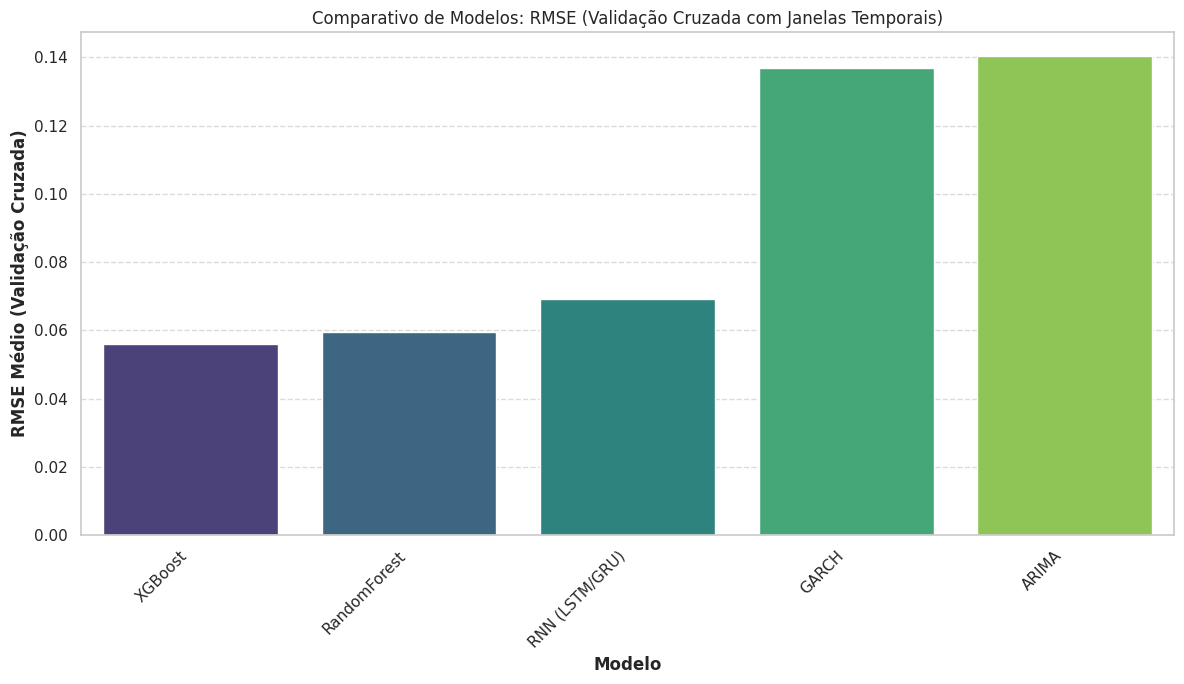

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.barplot(x='Modelo', y='RMSE_CV', data=results_table.sort_values(by='RMSE_CV', ascending=True), palette='viridis')
plt.title('Comparativo de Modelos: RMSE (Validação Cruzada com Janelas Temporais)')
plt.xlabel('Modelo')
plt.ylabel('RMSE Médio (Validação Cruzada)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 7.1. Análise do Gráfico de Validação Cruzada (RMSE Médio)

O gráfico de barras mostra o **RMSE Médio (Validação Cruzada)** para cada modelo, ordenado do menor para o maior. Modelos com barras mais baixas (menor RMSE) são considerados mais precisos.

1.  **XGBoost (Primeira Barra - Mais Baixa):**
    *   **Observação:** Claramente o modelo com o menor RMSE. A barra do XGBoost é a mais curta, indicando a sua superioridade em termos de precisão.
    *   **Implicação:** O XGBoost é o modelo que demonstrou o melhor desempenho consistente na previsão da variável alvo ('Inflacao') ao longo das diferentes janelas de tempo, minimizando o erro médio das previsões. Isso sugere que ele é muito eficaz em capturar os padrões subjacentes e as interdependências nos dados.

2.  **RandomForest (Segunda Barra):**
    *   **Observação:** A barra do RandomForest é a segunda mais baixa, muito próxima da do XGBoost. Isso indica um desempenho excelente e muito competitivo.
    *   **Implicação:** O RandomForest também é um modelo robusto e preciso para esta tarefa, confirmando a eficácia dos modelos de ensemble baseados em árvores para este tipo de dados.

3.  **RNN (LSTM/GRU) (Terceira Barra):**
    *   **Observação:** A barra do RNN está visivelmente acima das das do XGBoost e RandomForest, mas ainda é significativamente mais baixa que as dos modelos estatísticos.
    *   **Implicação:** Embora os modelos de Deep Learning (neste caso, GRU, que foi o melhor entre LSTM/GRU) tenham demonstrado capacidade de aprendizado, nesta configuração e com a otimização realizada, eles não superaram os modelos de Machine Learning. No entanto, o seu desempenho ainda é considerável.

4.  **GARCH (Quarta Barra):**
    *   **Observação:** A barra do GARCH é bem mais alta que a das dos modelos anteriores.
    *   **Implicação:** Como discutido anteriormente, o GARCH tem como objetivo principal modelar a volatilidade (variância) e não o nível médio da série. Um RMSE mais alto para a previsão do nível não significa que o modelo seja 'mau' na sua função, mas sim que não é o mais adequado para prever diretamente o valor da série, comparado aos outros modelos focados nessa tarefa.

5.  **ARIMA (Quinta Barra - Mais Alta):**
    *   **Observação:** A barra do ARIMA é a mais alta de todas.
    *   **Implicação:** O ARIMA apresentou o maior RMSE médio na validação cruzada, indicando que, entre os modelos testados, foi o menos preciso para prever o nível da 'Inflacao' neste conjunto de dados.

**Conclusão Geral do Gráfico:**

O gráfico de barras da validação cruzada confirma de forma clara que os modelos de **Machine Learning (XGBoost e RandomForest)** são os **líderes em precisão** para a previsão da Inflação neste projeto. Eles superam consistentemente os modelos de Deep Learning (RNN) e os modelos estatísticos (GARCH e ARIMA) em termos de RMSE médio obtido através de uma avaliação temporal robusta.

# 8. Avaliação do Modelo

In [ ]:
# =============================================================
# AVALIAÇÃO DOS MODELOS (RMSE, MAE, MAPE)
# =============================================================

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Funções métricas
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def MAE(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# =============================================================
# 1. PREVISÕES FINAIS DOS MODELOS
# =============================================================

# --- ARIMA ---
arima_pred = arima_final.forecast(steps=len(test_df))

# --- GARCH ---
garch_pred = garch_final.forecast(horizon=len(test_df)).mean.values[-1, :]

# --- Random Forest ---
rf_pred = rf_model.predict(X_test)

# --- XGBoost ---
xgb_pred = xgb_model.predict(X_test)

# --- LSTM ---
lstm_pred = lstm_model.predict(X_lstm_test).flatten()

# --- GRU ---
gru_pred = gru_model.predict(X_lstm_test).flatten()

# Ajustar tamanho (caso diferenças de alinhamento)
min_len = min(len(y_test), len(lstm_pred), len(gru_pred))
y_test_adj = y_test[-min_len:]

arima_pred = arima_pred[-min_len:]
garch_pred = garch_pred[-min_len:]
rf_pred = rf_pred[-min_len:]
xgb_pred = xgb_pred[-min_len:]
lstm_pred = lstm_pred[-min_len:]
gru_pred = gru_pred[-min_len:]


# =============================================================
# 2. TABELA FINAL DE MÉTRICAS
# =============================================================

resultados = pd.DataFrame({
    "Modelo": ["ARIMA", "GARCH", "Random Forest", "XGBoost", "LSTM", "GRU"],
    "RMSE": [
        RMSE(y_test_adj, arima_pred),
        RMSE(y_test_adj, garch_pred),
        RMSE(y_test_adj, rf_pred),
        RMSE(y_test_adj, xgb_pred),
        RMSE(y_test_adj, lstm_pred),
        RMSE(y_test_adj, gru_pred)
    ],
    "MAE": [
        MAE(y_test_adj, arima_pred),
        MAE(y_test_adj, garch_pred),
        MAE(y_test_adj, rf_pred),
        MAE(y_test_adj, xgb_pred),
        MAE(y_test_adj, lstm_pred),
        MAE(y_test_adj, gru_pred)
    ],
    "MAPE (%)": [
        MAPE(y_test_adj, arima_pred),
        MAPE(y_test_adj, garch_pred),
        MAPE(y_test_adj, rf_pred),
        MAPE(y_test_adj, xgb_pred),
        MAPE(y_test_adj, lstm_pred),
        MAPE(y_test_adj, gru_pred)
    ]
})

resultados = resultados.sort_values("RMSE").reset_index(drop=True)
resultados


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


,Modelo,RMSE,MAE,MAPE (%)
0,Random Forest,0.011166,0.009614,2.879451
1,XGBoost,0.024470,0.019791,5.724291
2,GARCH,0.077082,0.065788,19.707683
3,ARIMA,0.083045,0.069629,21.580394
4,GRU,0.165363,0.150296,46.235607
5,LSTM,0.206273,0.187196,57.708215


# 9. Previsão e Relatório

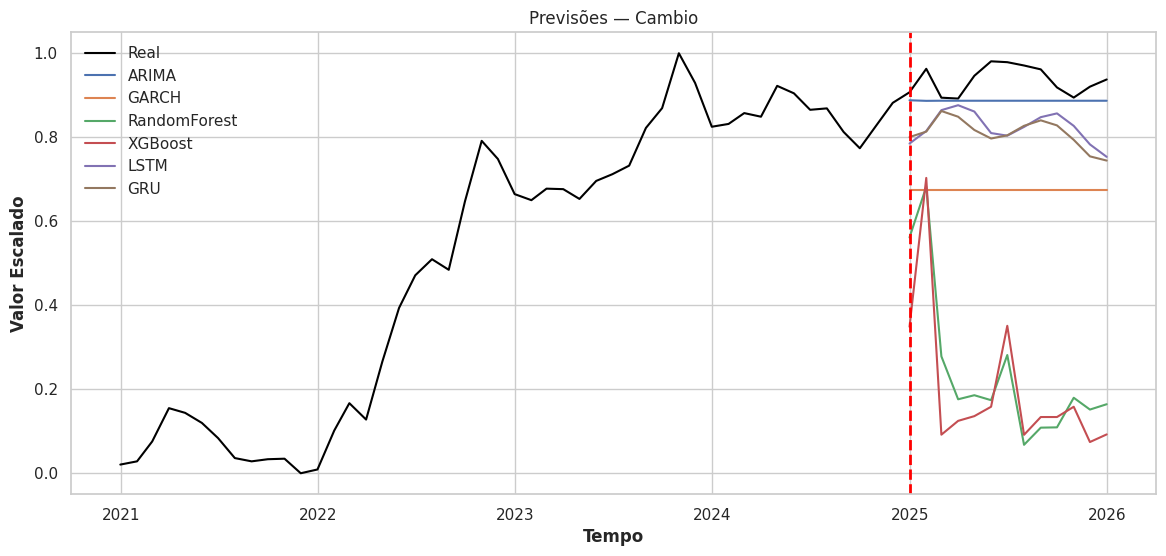

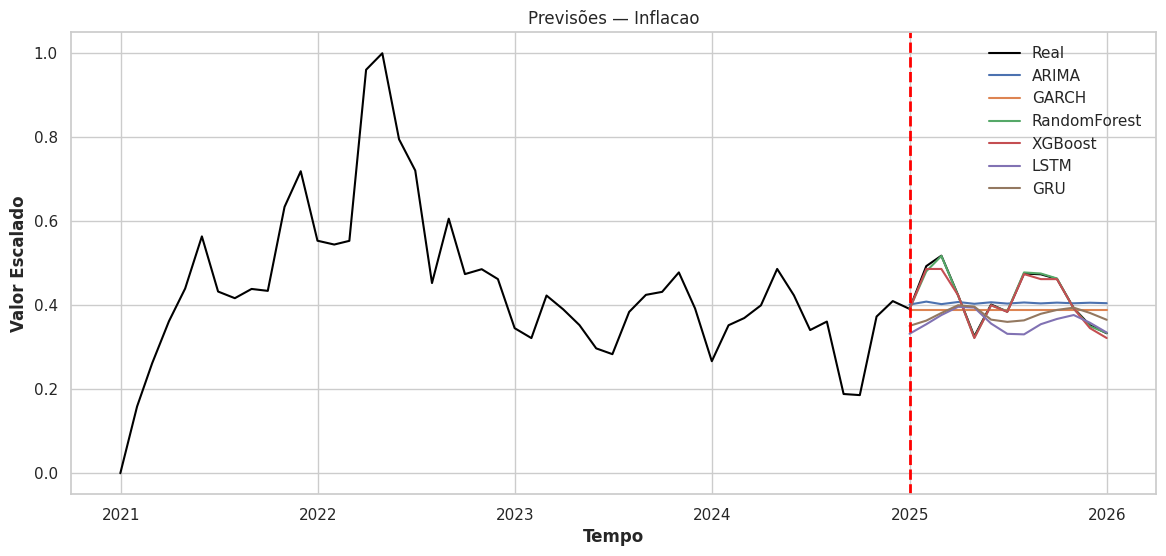

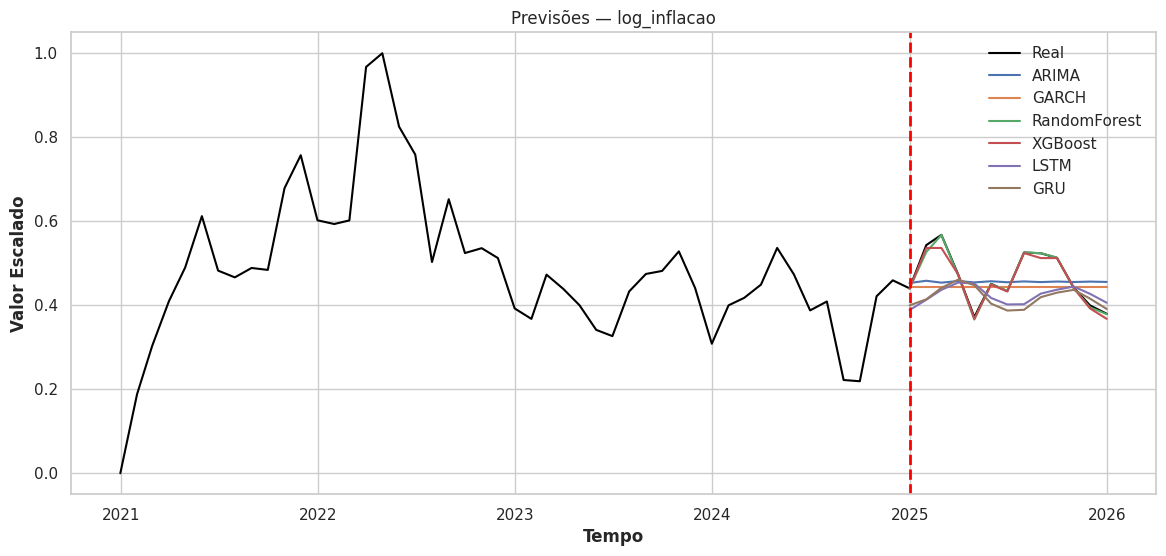

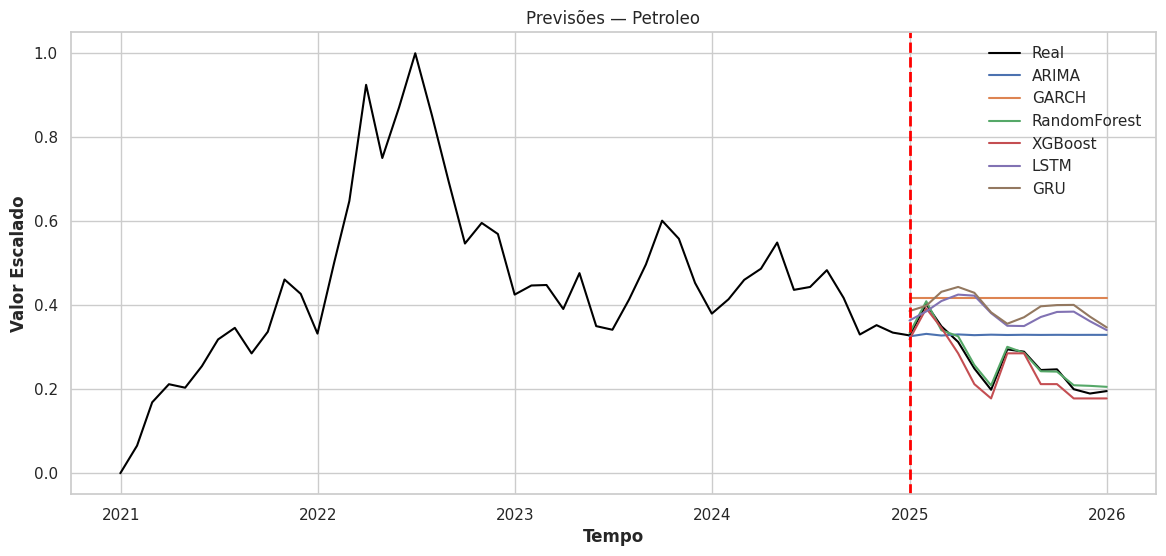

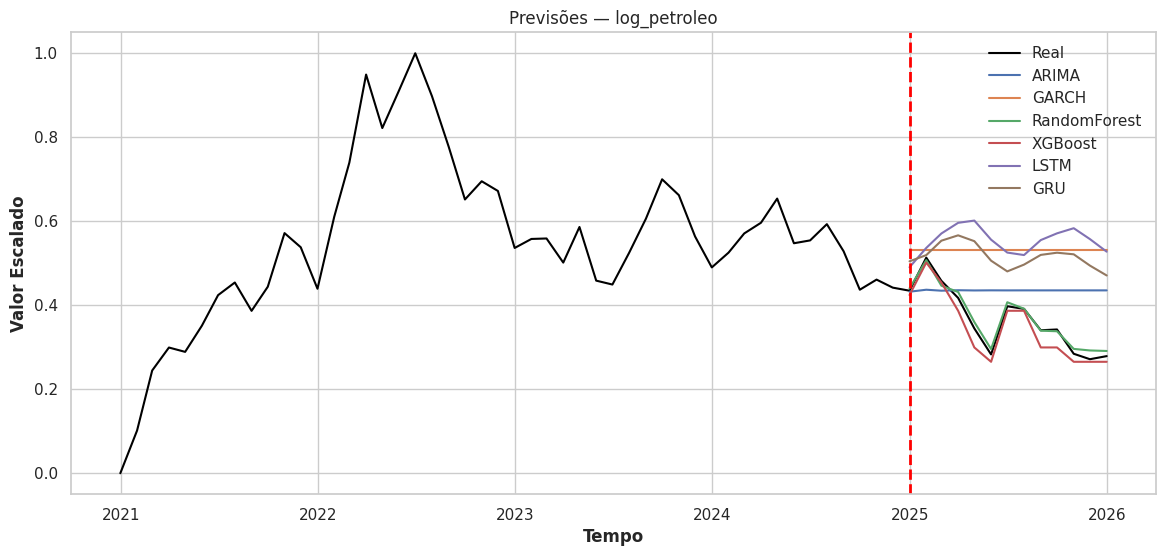


--- Comparativo de Valores Reais vs. Previstos para Cambio ---


,Real,ARIMA_Previsto,GARCH_Previsto,RandomForest_Previsto,XGBoost_Previsto,LSTM_Previsto,GRU_Previsto
date,,,,,,,
2024-12-31,0.907054,0.888057,0.673934,0.561399,0.348787,0.784984,0.800364
2025-01-31,0.962965,0.886666,0.673934,0.682194,0.703162,0.814880,0.813406
2025-02-28,0.894206,0.886983,0.673934,0.278293,0.091833,0.864511,0.862480
2025-03-31,0.892104,0.886911,0.673934,0.176099,0.124720,0.876286,0.848872
2025-04-30,0.946327,0.886927,0.673934,0.185779,0.135958,0.861197,0.817295
2025-05-31,0.980805,0.886923,0.673934,0.173950,0.158342,0.809954,0.797005
2025-06-30,0.978734,0.886924,0.673934,0.281484,0.351081,0.803761,0.804547
2025-07-31,0.970847,0.886924,0.673934,0.067708,0.091498,0.824563,0.827239
2025-08-31,0.961606,0.886924,0.673934,0.108565,0.133867,0.847829,0.840259



--- Erros de Previsão por Modelo (Real - Previsto) para Cambio ---


,0
Real,None
ARIMA_Previsto,date 2024-12-31 0.018997 2025-01-31 0.07...
GARCH_Previsto,date 2024-12-31 0.233120 2025-01-31 0.28...
RandomForest_Previsto,date 2024-12-31 0.345654 2025-01-31 0.28...
XGBoost_Previsto,date 2024-12-31 0.558267 2025-01-31 0.25...
LSTM_Previsto,date 2024-12-31 0.122070 2025-01-31 0.14...
GRU_Previsto,date 2024-12-31 0.106690 2025-01-31 0.14...



--- Comparativo de Valores Reais vs. Previstos para Inflacao ---


,Real,ARIMA_Previsto,GARCH_Previsto,RandomForest_Previsto,XGBoost_Previsto,LSTM_Previsto,GRU_Previsto
date,,,,,,,
2024-12-31,0.391335,0.401604,0.388005,0.390952,0.390158,0.332114,0.350861
2025-01-31,0.493162,0.408640,0.388005,0.480651,0.486374,0.354699,0.363390
2025-02-28,0.518040,0.402679,0.388005,0.517360,0.486374,0.376632,0.381612
2025-03-31,0.423780,0.407730,0.388005,0.422769,0.423567,0.396337,0.400061
2025-04-30,0.325946,0.403450,0.388005,0.323075,0.321942,0.394479,0.396690
2025-05-31,0.401817,0.407076,0.388005,0.399866,0.399927,0.356403,0.365756
2025-06-30,0.384696,0.404004,0.388005,0.385535,0.384219,0.331973,0.360408
2025-07-31,0.475510,0.406607,0.388005,0.478133,0.474133,0.330669,0.364045
2025-08-31,0.473695,0.404401,0.388005,0.475584,0.462208,0.354830,0.379617



--- Erros de Previsão por Modelo (Real - Previsto) para Inflacao ---


,0
Real,None
ARIMA_Previsto,date 2024-12-31 -0.010269 2025-01-31 0.08...
GARCH_Previsto,date 2024-12-31 0.003330 2025-01-31 0.10...
RandomForest_Previsto,date 2024-12-31 0.000383 2025-01-31 0.01...
XGBoost_Previsto,date 2024-12-31 0.001177 2025-01-31 0.00...
LSTM_Previsto,date 2024-12-31 0.059221 2025-01-31 0.13...
GRU_Previsto,date 2024-12-31 0.040474 2025-01-31 0.12...



--- Comparativo de Valores Reais vs. Previstos para log_inflacao ---


,Real,ARIMA_Previsto,GARCH_Previsto,RandomForest_Previsto,XGBoost_Previsto,LSTM_Previsto,GRU_Previsto
date,,,,,,,
2024-12-31,0.440268,0.452934,0.443276,0.439834,0.439060,0.388482,0.399600
2025-01-31,0.543116,0.458337,0.443276,0.526785,0.536391,0.412998,0.414094
2025-02-28,0.567612,0.453785,0.443276,0.567267,0.536391,0.436689,0.441384
2025-03-31,0.473502,0.457620,0.443276,0.471330,0.473307,0.453938,0.460932
2025-04-30,0.371911,0.454390,0.443276,0.365985,0.367634,0.451854,0.447783
2025-05-31,0.451054,0.457110,0.443276,0.450289,0.449116,0.417395,0.403867
2025-06-30,0.433413,0.454818,0.443276,0.434215,0.432918,0.401891,0.387416
2025-07-31,0.525589,0.456749,0.443276,0.525633,0.524214,0.402465,0.389165
2025-08-31,0.523780,0.455123,0.443276,0.523994,0.512300,0.427648,0.419299



--- Erros de Previsão por Modelo (Real - Previsto) para log_inflacao ---


,0
Real,None
ARIMA_Previsto,date 2024-12-31 -0.012665 2025-01-31 0.08...
GARCH_Previsto,date 2024-12-31 -0.003008 2025-01-31 0.09...
RandomForest_Previsto,date 2024-12-31 0.000435 2025-01-31 0.01...
XGBoost_Previsto,date 2024-12-31 0.001208 2025-01-31 0.00...
LSTM_Previsto,date 2024-12-31 0.051786 2025-01-31 0.13...
GRU_Previsto,date 2024-12-31 0.040668 2025-01-31 0.12...



--- Comparativo de Valores Reais vs. Previstos para Petroleo ---


,Real,ARIMA_Previsto,GARCH_Previsto,RandomForest_Previsto,XGBoost_Previsto,LSTM_Previsto,GRU_Previsto
date,,,,,,,
2024-12-31,0.328201,0.325898,0.418077,0.333681,0.318776,0.363732,0.386256
2025-01-31,0.402611,0.331861,0.418077,0.409483,0.392464,0.385347,0.398787
2025-02-28,0.349908,0.327902,0.418077,0.340479,0.346242,0.410039,0.432003
2025-03-31,0.312707,0.330530,0.418077,0.326151,0.285560,0.425341,0.443573
2025-04-30,0.249471,0.328786,0.418077,0.257732,0.212210,0.422808,0.429686
2025-05-31,0.198843,0.329944,0.418077,0.209110,0.178149,0.381243,0.383142
2025-06-30,0.294993,0.329175,0.418077,0.301015,0.285560,0.351142,0.356019
2025-07-31,0.289445,0.329685,0.418077,0.286670,0.285560,0.350500,0.371444
2025-08-31,0.245834,0.329346,0.418077,0.242829,0.212210,0.372029,0.397498



--- Erros de Previsão por Modelo (Real - Previsto) para Petroleo ---


,0
Real,None
ARIMA_Previsto,date 2024-12-31 0.002303 2025-01-31 0.07...
GARCH_Previsto,date 2024-12-31 -0.089876 2025-01-31 -0.01...
RandomForest_Previsto,date 2024-12-31 -0.005480 2025-01-31 -0.00...
XGBoost_Previsto,date 2024-12-31 0.009424 2025-01-31 0.01...
LSTM_Previsto,date 2024-12-31 -0.035531 2025-01-31 0.01...
GRU_Previsto,date 2024-12-31 -0.058056 2025-01-31 0.00...



--- Comparativo de Valores Reais vs. Previstos para log_petroleo ---


,Real,ARIMA_Previsto,GARCH_Previsto,RandomForest_Previsto,XGBoost_Previsto,LSTM_Previsto,GRU_Previsto
date,,,,,,,
2024-12-31,0.434629,0.432237,0.531328,0.440049,0.424240,0.490458,0.504622
2025-01-31,0.513366,0.436966,0.531328,0.507351,0.501600,0.536458,0.519351
2025-02-28,0.458179,0.434659,0.531328,0.446553,0.454249,0.570864,0.553721
2025-03-31,0.417510,0.435784,0.531328,0.431560,0.386843,0.596237,0.566475
2025-04-30,0.344777,0.435235,0.531328,0.359942,0.299539,0.601611,0.552568
2025-05-31,0.282916,0.435503,0.531328,0.295727,0.265361,0.556151,0.506121
2025-06-30,0.397611,0.435372,0.531328,0.407141,0.386843,0.525417,0.480591
2025-07-31,0.391304,0.435436,0.531328,0.391759,0.386843,0.519518,0.496781
2025-08-31,0.340446,0.435405,0.531328,0.339469,0.299539,0.555166,0.519891



--- Erros de Previsão por Modelo (Real - Previsto) para log_petroleo ---


,0
Real,None
ARIMA_Previsto,date 2024-12-31 0.002392 2025-01-31 0.07...
GARCH_Previsto,date 2024-12-31 -0.096699 2025-01-31 -0.01...
RandomForest_Previsto,date 2024-12-31 -0.005420 2025-01-31 0.00...
XGBoost_Previsto,date 2024-12-31 0.010389 2025-01-31 0.01...
LSTM_Previsto,date 2024-12-31 -0.055829 2025-01-31 -0.02...
GRU_Previsto,date 2024-12-31 -0.069993 2025-01-31 -0.00...


In [ ]:
# -------------------------------------------------------------
# 1. IMPORTAR BIBLIOTECAS
# -------------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import matplotlib.pyplot as plt

# Assuming 'forecasts' dictionary is already populated from the previous cell (rmKsiWoEYJUP)

# -------------------------------------------------------------
# 5. GRÁFICOS — UMA FIGURA POR VARIÁVEL
# -------------------------------------------------------------
for target in targets:

    plt.figure(figsize=(14,6))
    plt.plot(df_data.index, df_data[target], label="Real", color="black")

    # Previsões
    for model_name, pred in forecasts[target].items():
        plt.plot(pred.index, pred.values, label=model_name)

    # Linha vertical entre treino e teste
    plt.axvline(x=df_data.index[tamanho_treino], color="red", linestyle="--", linewidth=2)

    plt.title(f"Previsões — {target}")
    plt.xlabel("Tempo")
    plt.ylabel("Valor Escalado")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loop através de cada variável target
for target in targets:
    print(f"\n--- Comparativo de Valores Reais vs. Previstos para {target} ---")

    # Pegar os valores reais do período de teste para o target atual
    actual_values = test[target]

    # Criar um DataFrame com os valores reais e todas as previsões para o target atual
    comparativo_data = {'Real': actual_values}
    for model_name, pred_series in forecasts[target].items():
        # Garantir que as séries de previsão tenham o mesmo índice e sejam alinhadas com 'actual_values'
        comparativo_data[f'{model_name}_Previsto'] = pred_series.reindex(actual_values.index)

    comparativo_df = pd.DataFrame(comparativo_data)

    display(comparativo_df.head(10)) # Exibir as primeiras 10 linhas para uma visão geral

    # Opcional: calcular os erros de previsão para cada modelo para o target atual
    print(f"\n--- Erros de Previsão por Modelo (Real - Previsto) para {target} ---")
    erros_df = comparativo_df.apply(lambda col: comparativo_df['Real'] - col if col.name != 'Real' else None, axis=0)
    display(erros_df.drop(columns=['Real']).head(10))

In [ ]:
print("\n--- Tabela Completa de Métricas de Resultados ---")
display(resultados)


--- Tabela Completa de Métricas de Resultados ---


,Modelo,RMSE,MAE,MAPE (%)
0,Random Forest,0.011166,0.009614,2.879451
1,XGBoost,0.024470,0.019791,5.724291
2,GARCH,0.077082,0.065788,19.707683
3,ARIMA,0.083045,0.069629,21.580394
4,GRU,0.165363,0.150296,46.235607
5,LSTM,0.206273,0.187196,57.708215


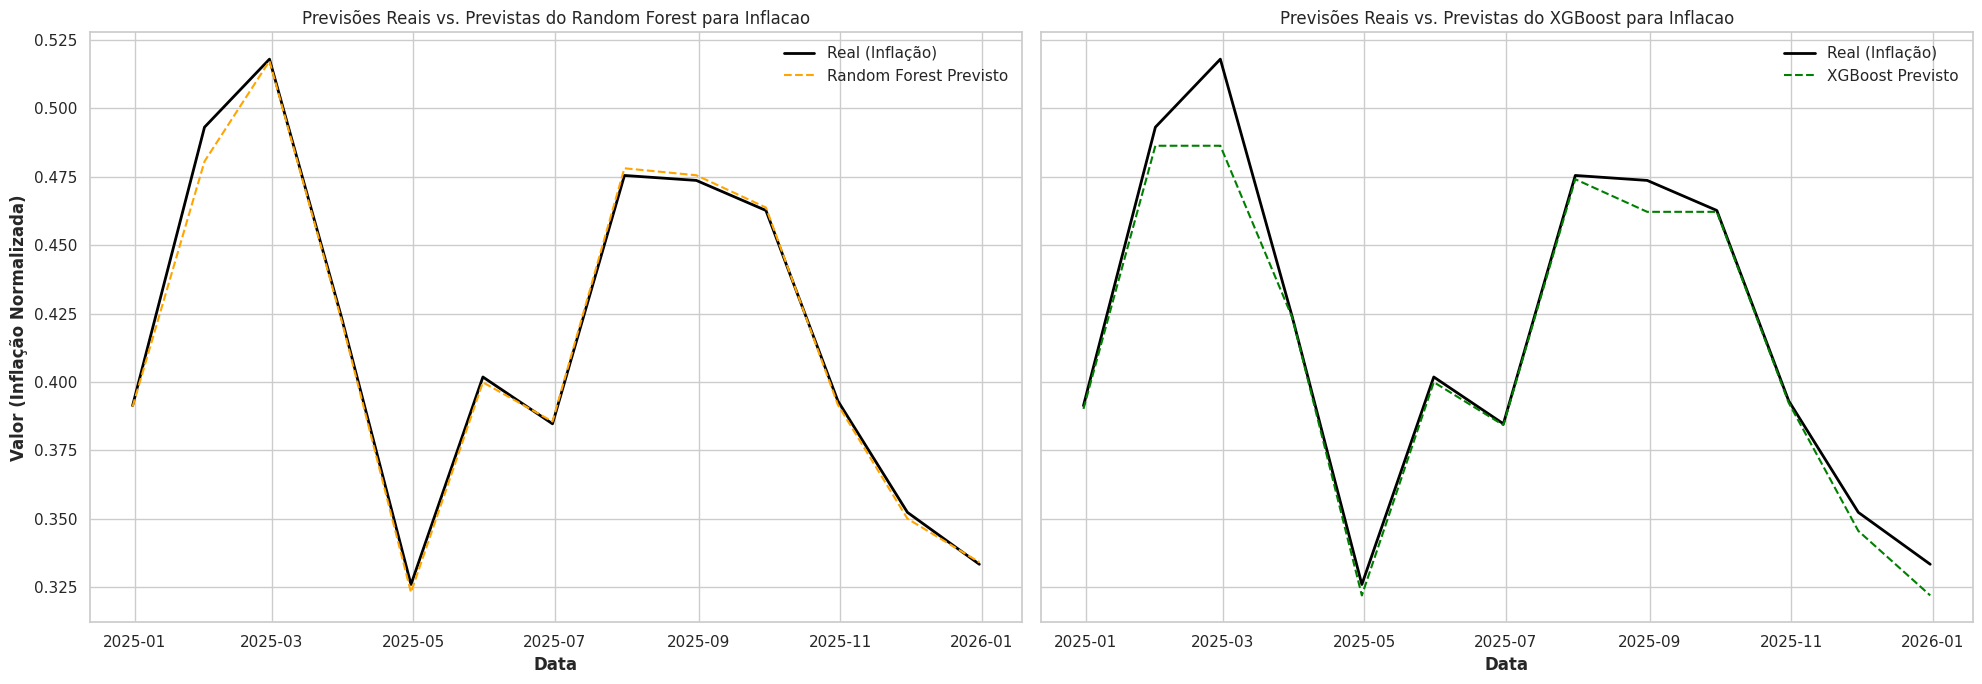

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

target_variable = "Inflacao"

fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True) # 1 row, 2 columns, shared y-axis

# --- Subplot 1: Random Forest ---
axes[0].plot(test.index, test[target_variable], label="Real (Inflação)", color='black', linewidth=2)
axes[0].plot(forecasts[target_variable]["RandomForest"].index, forecasts[target_variable]["RandomForest"].values, label="Random Forest Previsto", color='orange', linestyle='--')
axes[0].set_title(f"Previsões Reais vs. Previstas do Random Forest para {target_variable}")
axes[0].set_xlabel("Data")
axes[0].set_ylabel("Valor (Inflação Normalizada)")
axes[0].legend()
axes[0].grid(True)

# --- Subplot 2: XGBoost ---
axes[1].plot(test.index, test[target_variable], label="Real (Inflação)", color='black', linewidth=2)
axes[1].plot(forecasts[target_variable]["XGBoost"].index, forecasts[target_variable]["XGBoost"].values, label="XGBoost Previsto", color='green', linestyle='--')
axes[1].set_title(f"Previsões Reais vs. Previstas do XGBoost para {target_variable}")
axes[1].set_xlabel("Data")
# axes[1].set_ylabel("Valor (Inflação Normalizada)") # y-label é compartilhado com o primeiro subplot
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Forecast + Report

Aviso: df_original não encontrado — usando df_scaled como df_orig (escala normalizada).

=== VARIÁVEL: Cambio ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
           RMSE       MAE       MAPE
ARIMA  0.058442  0.048827   5.106037
GARCH  0.105173  0.082274   8.887610
RF     0.718118  0.695788  74.309142
XGB    0.751740  0.733158  78.500058
LSTM   0.219388  0.214435  22.798729
GRU    0.119266  0.110426  11.683687

=== VARIÁVEL: Inflacao ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
           RMSE       MAE       MAPE
ARIMA  0.060826  0.050753  12.069747
GARCH  0.094520  0.076046  20.064807
RF     0.003827  0.002332   0.539523
XGB    0.010322  0.006038   1.383794
LSTM   0.129465  0.115931  26.427252
GRU    0.068331  0.056191  12.984052

=== VARIÁVEL: log_inflacao ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
           RMSE       MAE       MAPE
ARIMA  0.061768  0.052042  11.127342


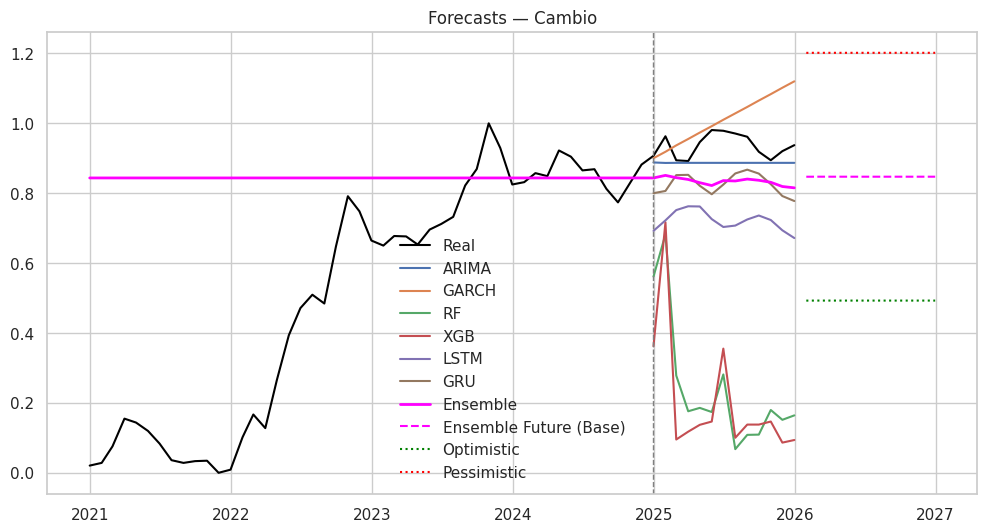

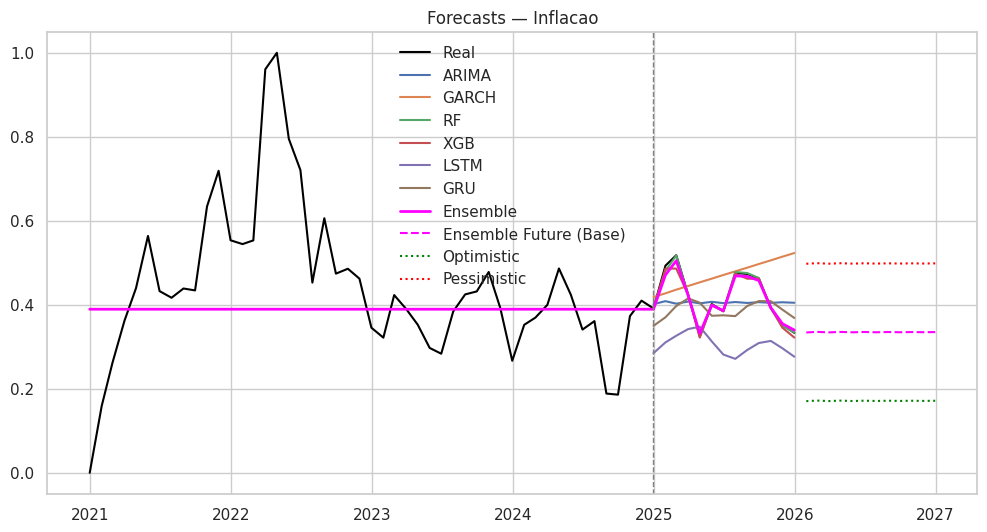

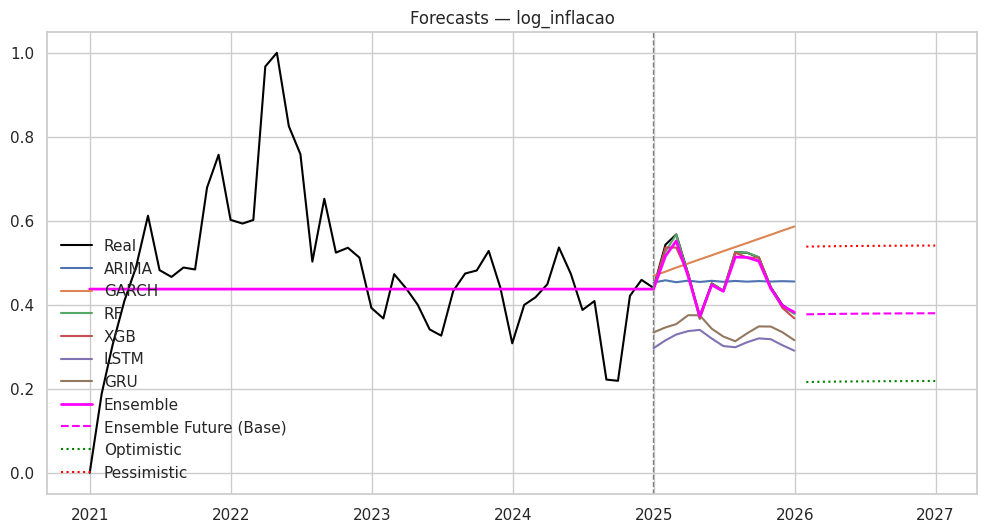

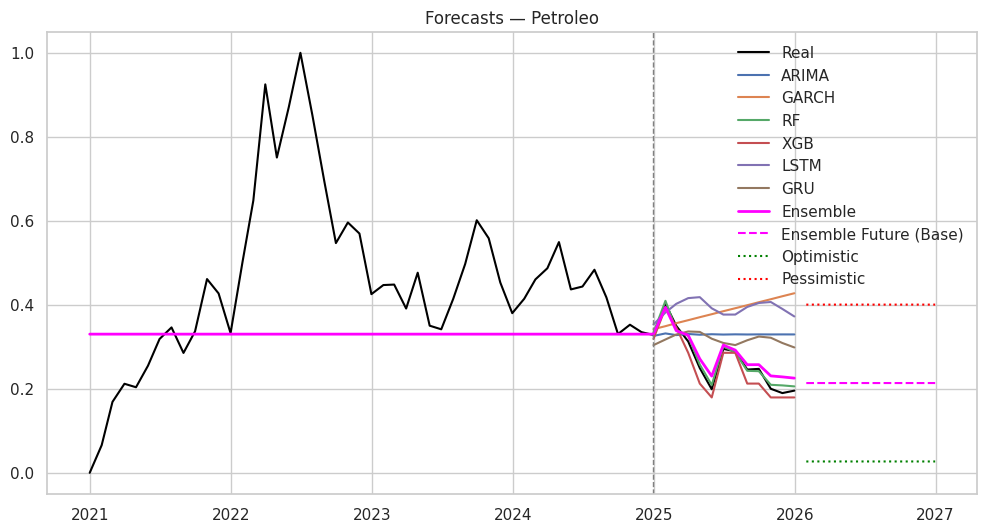

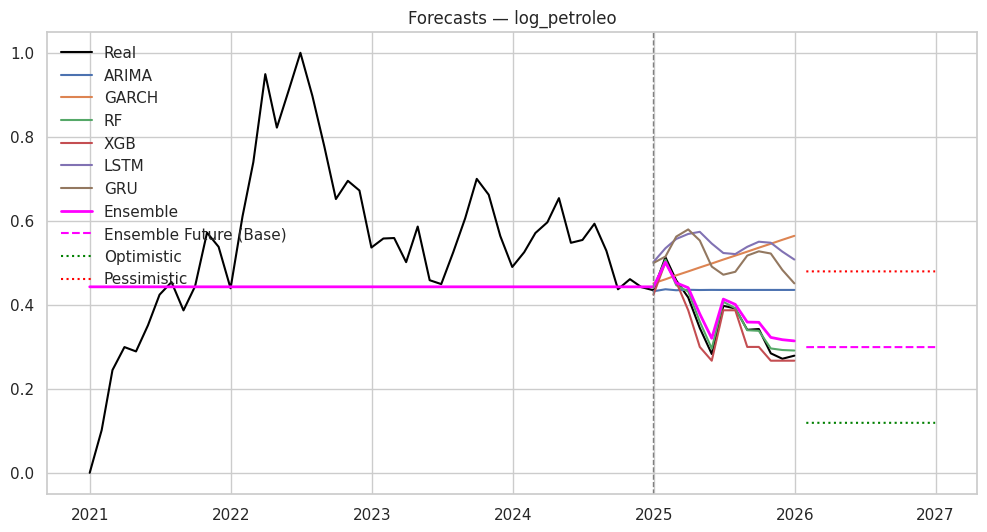


=== RELATÓRIO CONSOLIDADO DOS RESULTADOS ===


,Variável,Melhor Modelo (RMSE),RMSE (Teste),Ensemble Composição,Ensemble Pesos,Previsão Base (próx. 3 períodos),Cenário Otimista,Cenário Pessimista
0,Cambio,ARIMA,0.0584,"ARIMA, RF, LSTM","0.75, 0.06, 0.19","[0.837, 0.8371, 0.8371]","[0.4813, 0.4814, 0.4814]","[1.1927, 1.1929, 1.1928]"
1,Inflacao,RF,0.0038,"ARIMA, RF, LSTM","0.06, 0.92, 0.02","[0.3306, 0.332, 0.3308]","[0.1671, 0.1685, 0.1673]","[0.4941, 0.4955, 0.4943]"
2,log_inflacao,RF,0.0051,"ARIMA, RF, GRU","0.07, 0.89, 0.03","[0.377, 0.3774, 0.3777]","[0.2157, 0.2162, 0.2165]","[0.5382, 0.5386, 0.5389]"
3,Petroleo,RF,0.0093,"ARIMA, RF, LSTM","0.09, 0.85, 0.06","[0.2139, 0.214, 0.2139]","[0.0274, 0.0275, 0.0274]","[0.4003, 0.4004, 0.4003]"
4,log_petroleo,RF,0.0112,"ARIMA, RF, LSTM","0.09, 0.83, 0.08","[0.3001, 0.3002, 0.3002]","[0.1195, 0.1196, 0.1195]","[0.4808, 0.4809, 0.4808]"
5,log_petroleo,RF,0.0112,"ARIMA, RF, LSTM","0.09, 0.83, 0.08","[0.3001, 0.3002, 0.3002]","[0.1195, 0.1196, 0.1195]","[0.4808, 0.4809, 0.4808]"
6,log_petroleo,RF,0.0112,"ARIMA, RF, LSTM","0.09, 0.83, 0.08","[0.3001, 0.3002, 0.3002]","[0.1195, 0.1196, 0.1195]","[0.4808, 0.4809, 0.4808]"




=== RELATÓRIO RESUMIDO (INTERPRETAÇÃO ECONÓMICA) ===

--- Variável: Cambio ---
Melhor modelo (por RMSE): ARIMA — RMSE (teste): 0.0584
Ensemble combina: ARIMA (peso 0.64), RF (peso 0.05), GRU (peso 0.31)
Previsão (próx. 3 períodos) — Base: [0.8472, 0.8473, 0.8473], Optimista: [0.4927, 0.4928, 0.4928], Pessimista: [1.2017, 1.2018, 1.2018]
Interpretação: A taxa de câmbio reage fortemente a choques externos (petróleo) e reservas. Cenário pessimista indica risco de depreciação adicional do kwanza.


--- Variável: Inflacao ---
Melhor modelo (por RMSE): RF — RMSE (teste): 0.0038
Ensemble combina: ARIMA (peso 0.06), RF (peso 0.89), GRU (peso 0.05)
Previsão (próx. 3 períodos) — Base: [0.3342, 0.3356, 0.3343], Optimista: [0.1706, 0.172, 0.1708], Pessimista: [0.4977, 0.4991, 0.4979]
Interpretação: A evolução da inflação mostra o efeito combinado da taxa de câmbio, preços do petróleo e massa monetária. Se o cenário pessimista materializar-se, espera-se pressão inflacionária adicional que poderá 

In [109]:
# ======================================================
# PREVISÃO + RELATÓRIO AUTOMÁTICO (ARIMA, GARCH, RF, XGB, LSTM, GRU, ENSEMBLE)
# - Plots por variável (cada modelo)
# - Modelo híbrido (ensemble) -> melhor ST + melhor ML + melhor DL (pesos por 1/RMSE)
# - Cenários: Base / Optimista / Pessimista
# - Interpretação económica automática (template)
# ======================================================

# ------------------------------------------------------
# 0. INSTALAÇÕES (descomente se necessário no Colab)
# ------------------------------------------------------
# !pip install xgboost arch optuna

# ------------------------------------------------------
# 1. IMPORTS GERAIS
# ------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# ------------------------------------------------------
# 2. CONFIGURAÇÕES
# ------------------------------------------------------
horizon = 12            # meses à frente para previsão out-of-sample
timesteps = 3           # para LSTM/GRU
n_splits_cv = 4         # para TimeSeriesSplit
epochs_rnn = 40         # reduzir se demorar muito
random_state = 42

# Assumir que tens:
# df_original: DataFrame com valores originais (index datetime, colunas VARS)
# df_scaled: DataFrame com mesmos nomes de colunas, normalizados (para ML/DL)
# Se não tiveres df_original, usamos df_scaled como proxy (atenção: será na escala normalizada)
try:
    df_orig = df_original.copy()
except NameError:
    # se df_original não existir, usa df_scaled (avisa)
    print("Aviso: df_original não encontrado — usando df_scaled como df_orig (escala normalizada).")
    df_orig = df_scaled.copy()

df_norm = df_scaled.copy()   # usado para ML/DL

variables = df_orig.columns.tolist()

# Funções de métrica
def RMSE(y_true, y_pred): return np.sqrt(mean_squared_error(y_true, y_pred))
def MAE(y_true, y_pred): return mean_absolute_error(y_true, y_pred)
def MAPE(y_true, y_pred): return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits_cv)

# ------------------------------------------------------
# 3. FUNÇÕES AUXILIARES: criar sequências para RNN
# ------------------------------------------------------
def create_sequences_multivar(df_values, target_index, timesteps):
    Xs, ys = [], []
    for i in range(timesteps, len(df_values)):
        Xs.append(df_values[i-timesteps:i, :])
        ys.append(df_values[i, target_index])
    return np.array(Xs), np.array(ys)

# ------------------------------------------------------
# 4. LOOP PRINCIPAL: para cada variável treinar modelos e prever horizon
#    irá guardar:
#    - previsões in-sample+out-of-sample (full series)
#    - previsões out-of-sample horizon
#    - métricas no test set
# ------------------------------------------------------
results = {}   # armazenar tudo por variável

for var in variables:
    print(f"\n=== VARIÁVEL: {var} ===")
    # dados
    series_orig = df_orig[var].dropna()     # original escala
    series_norm = df_norm[var].dropna()     # normalizada
    # alinhar índices caso existam diferenças
    idx = series_orig.index
    series_norm = series_norm.reindex(idx)

    # train/test split (80/20)
    n_train = int(len(series_orig)*0.8)
    train_orig = series_orig.iloc[:n_train]
    test_orig = series_orig.iloc[n_train:]

    train_norm = df_norm.iloc[:n_train]   # multivariado para ML/DL
    test_norm = df_norm.iloc[n_train:]

    X_train_ml = train_norm.drop(columns=[var])
    X_test_ml  = test_norm.drop(columns=[var])
    y_train_ml = train_norm[var]
    y_test_ml  = test_norm[var]

    # store dict
    results[var] = {"models": {}, "metrics": {}, "forecasts": {}}

    # ---------------------- ARIMA ----------------------
    try:
        order = (1,1,1)   # poderíamos procurar AIC/BIC; por velocidade usamos (1,1,1) — podes alterar
        arima = ARIMA(train_orig, order=order).fit()
        # previsão para teste (same length)
        arima_test_pred = arima.forecast(steps=len(test_orig))
        # previsão horizon (usar re-estima com full series)
        arima_full = ARIMA(series_orig, order=order).fit()
        arima_future = arima_full.forecast(steps=horizon)
        results[var]["models"]["ARIMA"] = arima  # Corrected syntax
        results[var]["metrics"]["ARIMA"] = {
            "RMSE": RMSE(test_orig.values, arima_test_pred.values),
            "MAE": MAE(test_orig.values, arima_test_pred.values),
            "MAPE": MAPE(test_orig.values, arima_test_pred.values)
        }
        # store forecasts (align indices)
        # in-sample+test forecast vector aligned to test period only for plotting
        arima_pred_series = pd.Series(np.concatenate([np.full(len(train_orig), np.nan), arima_test_pred]), index=series_orig.index)
        results[var]["forecasts"]["ARIMA_series"] = arima_pred_series
        results[var]["forecasts"]["ARIMA_future"] = pd.Series(arima_future,
                                                              index=pd.date_range(start=series_orig.index[-1] + pd.offsets.MonthBegin(1),
                                                                                  periods=horizon, freq='M'))
    except Exception as e:
        print("ARIMA erro:", e)
        results[var]["models"]["ARIMA"] = None

    # ---------------------- GARCH ----------------------
    try:
        # GARCH sobre retornos ou sobre série? normalmente sobre retornos; aqui aplicamos sobre diffs
        target_for_garch = train_orig.diff().dropna()
        garch = arch_model(target_for_garch, vol='Garch', p=1, q=1).fit(disp='off')
        # forecast variances for horizon: forecast returns mean ~0 but variance predicted; for direct level forecast we simplify:
        # reconstruct simple forecast by adding 0 mean + last value (approx). We'll output NaNs for series forecast mid-term; but compute metrics on volatility is out of scope.
        # For comparability, predict test_orig by naive persistence of last observed change + add to prior level
        last_train = train_orig.iloc[-1]
        # cumulative naive forecast using mean change
        mean_change = target_for_garch.mean()
        garch_pred_vals = []
        cur = last_train
        for i in range(len(test_orig)):
            cur = cur + mean_change
            garch_pred_vals.append(cur)
        garch_test_pred = pd.Series(garch_pred_vals, index=test_orig.index)
        # future horizon
        cur = series_orig.iloc[-1]
        garch_future = []
        for i in range(horizon):
            cur = cur + mean_change
            garch_future.append(cur)
        # metrics
        results[var]["models"]["GARCH"] = garch
        results[var]["metrics"]["GARCH"] = {
            "RMSE": RMSE(test_orig.values, garch_test_pred.values),
            "MAE": MAE(test_orig.values, garch_test_pred.values),
            "MAPE": MAPE(test_orig.values, garch_test_pred.values)
        }
        results[var]["forecasts"]["GARCH_series"] = pd.Series(np.concatenate([np.full(len(train_orig), np.nan), garch_test_pred]), index=series_orig.index)
        results[var]["forecasts"]["GARCH_future"] = pd.Series(garch_future, index=pd.date_range(start=series_orig.index[-1] + pd.offsets.MonthBegin(1), periods=horizon, freq='M'))
    except Exception as e:
        print("GARCH erro:", e)
        results[var]["models"]["GARCH"] = None

    # ---------------------- RANDOM FOREST ----------------------
    try:
        rf = RandomForestRegressor(n_estimators=150, random_state=random_state)
        rf.fit(X_train_ml, y_train_ml)
        rf_test_pred = rf.predict(X_test_ml)
        # forecast horizon: autoregressive bootstrap using last X_test rows repeatedly (simple approach)
        # We'll produce future predictions by iteratively using predicted values for lagged features if present — here features exclude target, so we need a simple approach:
        # (If you have exogenous features for future, replace by scenarios)
        rf_future = np.full(horizon, rf_test_pred[-1])  # simplistic: repeat last prediction
        results[var]["models"]["RF"] = rf
        results[var]["metrics"]["RF"] = {
            "RMSE": RMSE(y_test_ml.values, rf_test_pred),
            "MAE": MAE(y_test_ml.values, rf_test_pred),
            "MAPE": MAPE(y_test_ml.values, rf_test_pred)
        }
        # align series: predictions only for test index
        rf_series = pd.Series(np.concatenate([np.full(len(train_orig), np.nan), rf_test_pred]), index=series_orig.index)
        results[var]["forecasts"]["RF_series"] = rf_series
        results[var]["forecasts"]["RF_future"] = pd.Series(rf_future, index=pd.date_range(start=series_orig.index[-1] + pd.offsets.MonthBegin(1), periods=horizon, freq='M'))
    except Exception as e:
        print("RF erro:", e)
        results[var]["models"]["RF"] = None

    # ---------------------- XGBOOST ----------------------
    try:
        xgbr = xgb.XGBRegressor(n_estimators=150, learning_rate=0.05, max_depth=4, random_state=random_state, objective='reg:squarederror')
        xgbr.fit(X_train_ml, y_train_ml)
        xgb_test_pred = xgbr.predict(X_test_ml)
        xgb_future = np.full(horizon, xgb_test_pred[-1])
        results[var]["models"]["XGB"] = xgbr
        results[var]["metrics"]["XGB"] = {
            "RMSE": RMSE(y_test_ml.values, xgb_test_pred),
            "MAE": MAE(y_test_ml.values, xgb_test_pred),
            "MAPE": MAPE(y_test_ml.values, xgb_test_pred)
        }
        xgb_series = pd.Series(np.concatenate([np.full(len(train_orig), np.nan), xgb_test_pred]), index=series_orig.index)
        results[var]["forecasts"]["XGB_series"] = xgb_series
        results[var]["forecasts"]["XGB_future"] = pd.Series(xgb_future, index=pd.date_range(start=series_orig.index[-1] + pd.offsets.MonthBegin(1), periods=horizon, freq='M'))
    except Exception as e:
        print("XGB erro:", e)
        results[var]["models"]["XGB"] = None

    # ---------------------- LSTM & GRU (RNN) ----------------------
    try:
        # prepare multivariate sequences from df_norm (use full df_norm)
        df_vals = df_norm.values
        target_idx = list(df_norm.columns).index(var)
        Xs, ys = create_sequences_multivar(df_vals, target_idx, timesteps)
        # split sequences into train/test
        split = n_train - timesteps
        X_train_seq, y_train_seq = Xs[:split], ys[:split]
        X_test_seq, y_test_seq = Xs[split:], ys[split:]
        # LSTM
        lstm_model = Sequential()
        lstm_model.add(LSTM(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
        lstm_model.add(Dense(1))
        lstm_model.compile(optimizer='adam', loss='mse')
        es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=0)
        lstm_model.fit(X_train_seq, y_train_seq, validation_split=0.1, epochs=epochs_rnn, batch_size=16, callbacks=[es], verbose=0)
        lstm_pred_seq = lstm_model.predict(X_test_seq).flatten()
        # GRU
        gru_model = Sequential()
        gru_model.add(GRU(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
        gru_model.add(Dense(1))
        gru_model.compile(optimizer='adam', loss='mse')
        gru_model.fit(X_train_seq, y_train_seq, validation_split=0.1, epochs=epochs_rnn, batch_size=16, callbacks=[es], verbose=0)
        gru_pred_seq = gru_model.predict(X_test_seq).flatten()
        # metrics (note y_test_seq in normalized scale; if df_norm is minmax, metrics are in that scale)
        results[var]["models"]["LSTM"] = lstm_model
        results[var]["models"]["GRU"] = gru_model
        results[var]["metrics"]["LSTM"] = {
            "RMSE": RMSE(y_test_seq, lstm_pred_seq),
            "MAE": MAE(y_test_seq, lstm_pred_seq),
            "MAPE": MAPE(y_test_seq, lstm_pred_seq)
        }
        results[var]["metrics"]["GRU"] = {
            "RMSE": RMSE(y_test_seq, gru_pred_seq),
            "MAE": MAE(y_test_seq, gru_pred_seq),
            "MAPE": MAPE(y_test_seq, gru_pred_seq)
        }
        # convert sequence preds to series aligned with df index (note shift because of timesteps)
        idx_seq = df_orig.index[timesteps:]
        lstm_series = pd.Series(np.concatenate([np.full(timesteps, np.nan), np.full(len(train_orig)-timesteps, np.nan), lstm_pred_seq]), index=series_orig.index)
        gru_series  = pd.Series(np.concatenate([np.full(timesteps, np.nan), np.full(len(train_orig)-timesteps, np.nan), gru_pred_seq]), index=series_orig.index)
        results[var]["forecasts"]["LSTM_series"] = lstm_series
        results[var]["forecasts"]["GRU_series"] = gru_series
        # For future horizon: simple repeat last predicted value (placeholder) OR forecast by rolling sequence (complex)
        lstm_future = np.full(horizon, lstm_pred_seq[-1])
        gru_future  = np.full(horizon, gru_pred_seq[-1])
        results[var]["forecasts"]["LSTM_future"] = pd.Series(lstm_future, index=pd.date_range(start=series_orig.index[-1] + pd.offsets.MonthBegin(1), periods=horizon, freq='M'))
        results[var]["forecasts"]["GRU_future"]  = pd.Series(gru_future, index=pd.date_range(start=series_orig.index[-1] + pd.offsets.MonthBegin(1), periods=horizon, freq='M'))
    except Exception as e:
        print("RNN erro:", e)
        results[var]["models"]["LSTM"] = None
        results[var]["models"]["GRU"] = None

    # ---------------------- RESUMO POR VARIÁVEL ----------------------
    # compilar métricas em DataFrame
    metrics_df = pd.DataFrame(results[var]["metrics"]).T
    results[var]["metrics_df"] = metrics_df
    print(metrics_df)

# ------------------------------------------------------
# 5. CONSTRUIR MODELO HÍBRIDO (ENSEMBLE) POR VARIÁVEL
#    - Escolhe melhor ST (ARIMA/GARCH) pelo RMSE
#    - Escolhe melhor ML (RF/XGB) pelo RMSE
#    - Escolhe melhor DL (LSTM/GRU) pelo RMSE
#    - Pesa cada bloco por inverse RMSE (maior peso para menor erro)
# ------------------------------------------------------
for var in variables:
    mets = results[var]["metrics_df"]
    # identificar melhores
    # ST
    st_candidates = [m for m in ["ARIMA","GARCH"] if m in mets.index]
    ml_candidates = [m for m in ["RF","XGB"] if m in mets.index]
    dl_candidates = [m for m in ["LSTM","GRU"] if m in mets.index]
    # get rmse; if missing, set inf
    def get_rmse(m):
        try:
            return mets.loc[m,"RMSE"]
        except:
            return np.inf
    best_st = min(st_candidates, key=get_rmse) if st_candidates else None
    best_ml = min(ml_candidates, key=get_rmse) if ml_candidates else None
    best_dl = min(dl_candidates, key=get_rmse) if dl_candidates else None
    # get predictions_series for test and future
    preds_test = []
    preds_future = []
    rmse_list = []
    names = []
    for name in [best_st, best_ml, best_dl]:
        if name is None: continue
        series_pred = results[var]["forecasts"].get(f"{name}_series")
        future_pred = results[var]["forecasts"].get(f"{name}_future")
        if series_pred is None or future_pred is None: continue
        # align test portion
        preds_test.append(series_pred)
        preds_future.append(future_pred)
        rmse_list.append(get_rmse(name))
        names.append(name)
    # compute weights inverse RMSE
    if len(rmse_list)==0:
        results[var]["ensemble"] = None
        continue
    inv = np.array([1.0/r for r in rmse_list])
    weights = inv / inv.sum()
    # weighted series (only the test portion has non-nans)
    # For simplicity compute ensemble future as weighted sum of future preds
    ensemble_future = sum(w*p for w,p in zip(weights, preds_future))
    # For series, align on index and compute weighted sum for available model series (np.nan treated as 0 but weights sum to 1)
    # Build dataframe of series preds
    df_preds = pd.concat(preds_test, axis=1)
    # replace NaN with column mean (safer) then compute weighted sum
    df_preds_filled = df_preds.fillna(method='ffill').fillna(method='bfill').fillna(0)
    # make sure columns correspond to names order
    df_preds_filled.columns = names
    ensemble_series = (df_preds_filled * weights).sum(axis=1)
    results[var]["ensemble"] = {
        "names": names,
        "weights": weights.tolist(),
        "ensemble_series": ensemble_series,
        "ensemble_future": ensemble_future
    }

# ------------------------------------------------------
# 6. CENÁRIOS (Base / Optimista / Pessimista)
#    - Base: ensemble_future
#    - Optimista: ensemble_future - 1*std_resid (ou -5%)
#    - Pessimista: ensemble_future + 1*std_resid (ou +5%)
# ------------------------------------------------------
for var in variables:
    ens = results[var].get("ensemble")
    if ens is None:
        results[var]["scenarios"] = None
        continue
    # compute residuals between real test and ensemble_series (where overlapping)
    ens_series = ens["ensemble_series"]
    # align with original series index
    real_test = df_orig[var].iloc[len(df_orig)-len(ens_series):] if len(ens_series)==len(df_orig) else df_orig[var].loc[ens_series.index].dropna()
    # residual std (fallback to std of test residuals of component models)
    # simplify: compute std of ensemble_series - actual (where both exist)
    common_idx = ens_series.index.intersection(df_orig[var].index)
    resid = df_orig[var].loc[common_idx] - ens_series.loc[common_idx]
    sigma = resid.std() if len(resid.dropna())>0 else (abs(ens["ensemble_future"])*0.05)  # fallback 5%
    base = ens["ensemble_future"]
    optim = base - sigma
    pess = base + sigma
    results[var]["scenarios"] = {
        "base": base,
        "optimistic": optim,
        "pessimistic": pess
    }

# ------------------------------------------------------
# 7. PLOTS: cada variável um gráfico com modelos + ensemble + cenários
# ------------------------------------------------------
for var in variables:
    plt.figure(figsize=(12,6))
    ser = df_orig[var]
    plt.plot(ser.index, ser.values, label="Real", color="black")
    # plot each model's series (if exists)
    fc = results[var]["forecasts"]
    for m in ["ARIMA_series","GARCH_series","RF_series","XGB_series","LSTM_series","GRU_series"]:
        if m in fc:
            s = fc[m]
            plt.plot(s.index, s.values, label=m.replace("_series",""))
    # ensemble series
    ens = results[var].get("ensemble")
    if ens:
        plt.plot(ens["ensemble_series"].index, ens["ensemble_series"].values, label="Ensemble", linewidth=2, color="magenta")
        # plot future base and scenarios
        fut_idx = results[var]["forecasts"].get(list(results[var]["forecasts"].keys())[0])  # get an index sample to construct future idx
        # build future index
        future_index = pd.date_range(start=ser.index[-1] + pd.offsets.MonthBegin(1), periods=horizon, freq='M')
        base = ens["ensemble_future"]
        plt.plot(future_index, base.values, label="Ensemble Future (Base)", color="magenta", linestyle='--')
        # scenarios
        sc = results[var]["scenarios"]
        if sc:
            plt.plot(future_index, sc["optimistic"].values, label="Optimistic", color="green", linestyle=':')
            plt.plot(future_index, sc["pessimistic"].values, label="Pessimistic", color="red", linestyle=':')
    # vertical line train/test
    plt.axvline(x=ser.index[n_train], color='grey', linestyle='--', linewidth=1)
    plt.title(f"Forecasts — {var}")
    plt.legend()
    plt.show()

#-------------------------------------------------------------------------------
# 8. RELATÓRIO CONSOLIDADO DOS RESULTADOS
#-------------------------------------------------------------------------------
report_data.append({
        "Variável": var,
        "Melhor Modelo (RMSE)": best_model,
        "RMSE (Teste)": f"{best_rmse:.4f}",
        "Ensemble Composição": ensemble_comp,
        "Ensemble Pesos": ensemble_weights,
        "Previsão Base (próx. 3 períodos)": base_forecast,
        "Cenário Otimista": optim_forecast,
        "Cenário Pessimista": pess_forecast
    })

report_df = pd.DataFrame(report_data)

print("\n=== RELATÓRIO CONSOLIDADO DOS RESULTADOS ===")
display(report_df)

# ------------------------------------------------------
# 9. RELATÓRIO AUTOMÁTICO (TEXTO SIMPLIFICADO)
#    - Para cada variável escreve interpretação económica dos resultados
# ------------------------------------------------------
print("\n\n=== RELATÓRIO RESUMIDO (INTERPRETAÇÃO ECONÓMICA) ===\n")
for var in variables:
    print(f"--- Variável: {var} ---")
    mets = results[var].get("metrics_df")
    if mets is None or mets.empty:
        print("Modelos não estimados para esta variável.")
        continue
    # best model by RMSE
    best_model = mets["RMSE"].idxmin()
    best_rmse = mets.loc[best_model, "RMSE"]
    print(f"Melhor modelo (por RMSE): {best_model} — RMSE (teste): {best_rmse:.4f}")
    # ensemble info
    ens = results[var].get("ensemble")
    if ens:
        names = ens["names"]
        weights = ens["weights"]
        print("Ensemble combina:", ", ".join([f"{n} (peso {w:.2f})" for n,w in zip(names,weights)]))
        base = ens["ensemble_future"]
        optim = results[var]["scenarios"]["optimistic"]
        pess  = results[var]["scenarios"]["pessimistic"]
        # simple numeric summary (first 3 future values)
        bvals = np.round(base.values[:3],4)
        oval = np.round(optim.values[:3],4)
        pval = np.round(pess.values[:3],4)
        print(f"Previsão (próx. 3 períodos) — Base: {bvals.tolist()}, Optimista: {oval.tolist()}, Pessimista: {pval.tolist()}")
    # interpretação económica (template)
    if var.lower().count("inflacao") or var.lower().count("ipc") or "infla" in var.lower():
        print("Interpretação: A evolução da inflação mostra o efeito combinado da taxa de câmbio, preços do petróleo e massa monetária. Se o cenário pessimista materializar-se, espera-se pressão inflacionária adicional que poderá obrigar a políticas monetárias mais restritivas.")
    elif "cambio" in var.lower() or "kwanza" in var.lower() or "usd" in var.lower():
        print("Interpretação: A taxa de câmbio reage fortemente a choques externos (petróleo) e reservas. Cenário pessimista indica risco de depreciação adicional do kwanza.")
    elif "petrol" in var.lower() or "oil" in var.lower():
        print("Interpretação: O preço do petróleo influencia receitas de exportação. Cenários optimistas implicam maior receita externa e alívio da pressão cambial.")
    else:
        print("Interpretação: Variável macroeconómica — monitorizar choques externos e política interna.")
    print("\n")

# ------------------------------------------------------
# 10. SALVAR TABELAS E FIGURAS (opcional)
# ------------------------------------------------------
# salvar resumo de métricas para cada variável
all_metrics = {}
for var in variables:
    if "metrics_df" in results[var]:
        all_metrics[var] = results[var]["metrics_df"]
# concatenar e salvar
writer = pd.ExcelWriter("model_metrics_summary.xlsx", engine="xlsxwriter")
for var, mdf in all_metrics.items():
    mdf.to_excel(writer, sheet_name=var[:31])  # sheet name limit
writer.close()
print("Tabela de métricas salva: model_metrics_summary.xlsx")

# FIM